In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

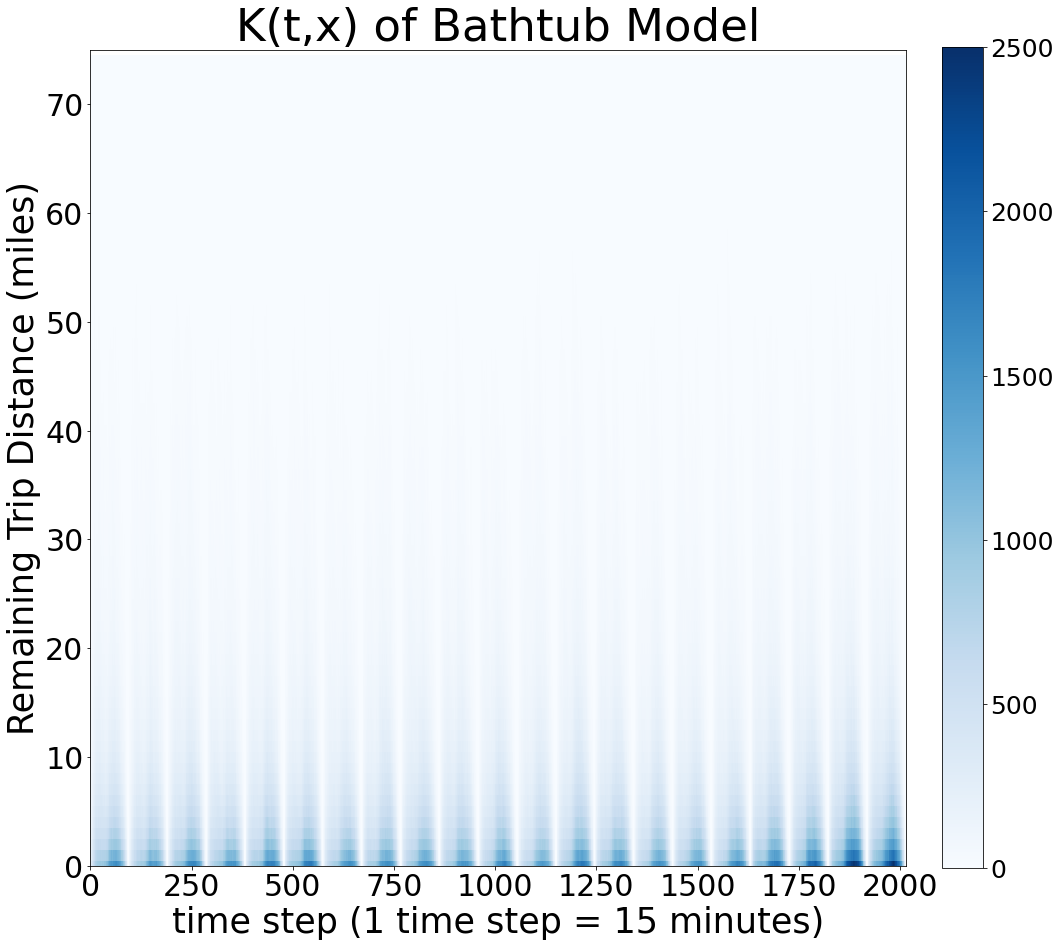

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 5 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  30240
N_u =  6048
N_f =  12096


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(6048, 2)

In [12]:
X_u_test.shape

(24192, 2)

In [13]:
X_u_train

array([[0.        , 0.02630273],
       [0.54054054, 0.8382134 ],
       [0.94594595, 0.23722084],
       ...,
       [0.47297297, 0.98957816],
       [0.06756757, 0.87394541],
       [0.54054054, 0.92704715]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.019410603831126826 0.029189186919176227 0.0096320207430774223 1.2995824628393522
0.00841861794066561 0.016552430224104325 0.00028480565722689368 0.9862867545311638
0.0081566622928020849 0.015970221152633048 0.00034310343297112085 0.9688766132109209
0.0070976535570627091 0.013727929979403008 0.00046737713472240938 0.8981146701625136
0.0060183634680731589 0.011249867153284524 0.00078685978286179372 0.8131019932162238
0.005534975814250216 0.0097868411606342551 0.0012831104678661766 0.7594298912385908
0.0052245072479139548 0.0095666314383343349 0.00088238305749357374 0.750957890961038
0.005215033625271398 0.0095454446179156233 0.00088462263262717217 0.750186641322572
0.005160523788904592 0.0094994630480025842 0.00082158452980660038 0.7486478760199472
0.0050799424310842469 0.0094904261430413736 0.00066945871912711934 0.7485244405747835
0.0049364869195972589 0.0094289780159413829 0.0004439958232531341 0.7463207297766106
0.0047958737150252551 0.009151515008819406 0.00044023242123110347 0.73

0.0031954686502847392 0.0054698685923916289 0.00092106870817784973 0.5720633189087082
0.0031949751664882274 0.0054718184710121961 0.00091813186196425831 0.5721743599781692
0.0031941194312940053 0.0054782752592494937 0.0009099636033385168 0.57251000150002
0.0031929651518268149 0.0054876542900194544 0.00089827601363417554 0.5730038178760564
0.0031921622325967935 0.0054924538215924768 0.00089187064360111046 0.5732387131222068
0.003190339870272234 0.00547077111976832 0.00090990862077614746 0.5721376471981158
0.00318823154330849 0.0054509781080343909 0.00092548497858258927 0.5710612350511255
0.00318669788061879 0.005463467813988313 0.00090992794724926768 0.5716504607883413
0.0031846700729988606 0.0054966073900199371 0.00087273275597778426 0.5730319408960937
0.0031820442719817338 0.0054392627202427832 0.00092482582372068465 0.5700286992402531
0.0031809207013898605 0.0054513569021018039 0.00091048450067791756 0.5706611596690669
0.0031799470900992916 0.0054489455053073387 0.0009109486748912447

0.0031711440581284442 0.0054366410099243217 0.00090564710633256665 0.5698161676321001
0.0031711401595170595 0.0054367775891183247 0.00090550272991579467 0.5698220122663274
0.0031711306659782052 0.0054375318795520673 0.00090472945240434267 0.5698615493559944
0.0031711085949235733 0.0054379091716652041 0.00090430801818194243 0.5698814726362793
0.0031710632781541247 0.00543878547774257 0.00090334107856567892 0.5699320301438254
0.00317099976493987 0.0054384846711384351 0.00090351485874130485 0.5699247117438546
0.0031709408992794679 0.0054375729179238627 0.00090430888063507283 0.5698923109920704
0.0031709166547987562 0.0054356790071324965 0.0009061543024650163 0.5698031235669815
0.0031708998528007805 0.0054349717624034392 0.00090682794319812173 0.5697693689493065
0.0031708691307058287 0.0054343248343878851 0.00090741342702377217 0.5697394492267666
0.0031708489424966471 0.0054357952671618024 0.00090590261783149158 0.5698222533784363
0.0031708421960289454 0.0054337524852303464 0.0009079319068

0.0031575750646505637 0.0054091697084042651 0.00090598042089686187 0.5683276060120472
0.0031571672135041573 0.0054284274321997616 0.00088590699480855259 0.5692998538914266
0.0031567103441163375 0.0054179036434772289 0.00089551704475544628 0.5688135387846013
0.0031562177148402896 0.00540334083578457 0.00090909459389600881 0.5680366981335762
0.0031556560266085484 0.0054085768559067708 0.00090273519731032628 0.5682347806549165
0.0031555387836201682 0.00540574302090936 0.00090533454633097551 0.5681018732080031
0.0031553745962380063 0.0054069052186968124 0.0009038439737792 0.5681998386759481
0.0031553125385820739 0.0054086125430475359 0.0009020125341166115 0.5682648994247697
0.00315526445534842 0.0054070336665671881 0.000903495244129652 0.5681858844019887
0.003155225193912461 0.005406002178876013 0.00090444820894890925 0.5681299424664498
0.0031551943525796062 0.0054055536404874222 0.00090483506467178983 0.5681111579213978
0.0031551046761120623 0.00540294799599897 0.00090726135622515509 0.56

0.0030862214586715774 0.0053184029315370435 0.00085403998580611123 0.5628725422638882
0.0030858402924731189 0.0053130508956998248 0.00085862968924641317 0.562655383675185
0.0030852040246780251 0.0053165232050168152 0.00085388484433923456 0.5628377252935627
0.0030836215103445582 0.0053200944827347992 0.00084714853795431753 0.5629917083447984
0.0030827571389246242 0.0053281266070959316 0.0008373876707533167 0.5635147218485613
0.0030820995105878555 0.0053191746710429871 0.00084502435013272413 0.5628986190386482
0.0030811239599177619 0.0053058673604878476 0.00085638055934767615 0.5622086241454494
0.0030803690976121409 0.0052991949591072911 0.00086154323611699042 0.5619258757010461
0.0030797639843513636 0.0052950254265623524 0.00086450254214037508 0.5616449942574411
0.0030795189398790846 0.0052819398428995273 0.00087709803685864156 0.5609943664247862
0.0030792931071305543 0.00529207097420035 0.00086651524006075827 0.5614933278698573
0.0030792099607834357 0.0052910046619907263 0.000867415259

0.0030528498565269625 0.0052637790792913189 0.00084192063376260578 0.5602881046007318
0.0030528164122363881 0.0052634541594387364 0.00084217866503404006 0.5602746928871378
0.0030527639158895339 0.0052644904320002309 0.00084103739977883687 0.5603264841948423
0.0030527000759349087 0.0052671888972587455 0.00083821125461107219 0.5604592044631095
0.0030525727698117772 0.0052680005354379129 0.00083714500418564128 0.5604857023183634
0.0030523298465626684 0.00526962281633496 0.00083503687679037592 0.5605429117806668
0.0030521182686996775 0.005266212220989038 0.00083802431641031737 0.5603542765998972
0.0030519888419126406 0.0052681106298449612 0.00083586705398031958 0.5604508134441704
0.0030517833549112924 0.0052650075894966645 0.00083855912032592 0.5603143821025849
0.00305166517404304 0.0052617804323270671 0.00084154991575901292 0.5601424576105296
0.0030515578693473436 0.0052611732560747118 0.0008419424826199756 0.5601202209620945
0.0030514766705515418 0.0052623912273673627 0.00084056211373572

0.0030397900556001583 0.0052384107270649731 0.00084116938413534323 0.5589790119445619
0.0030397576974382835 0.0052391308488783789 0.00084038454599818829 0.5590249400244671
0.0030397080677510781 0.0052393874436085083 0.00084002869189364756 0.5590345221425512
0.003039635838002412 0.0052396652408086448 0.00083960643519617945 0.5590504555087658
0.0030395069793169851 0.0052393255435144621 0.000839688415119508 0.5590260900063188
0.0030394246569573897 0.0052351676391741578 0.00084368167474062155 0.5588014123346735
0.0030394104876673789 0.0052363732163667924 0.00084244775896796537 0.5588650085904513
0.0030393851286801919 0.0052357400150131123 0.00084303024234727174 0.5588549118981575
0.0030393609727215882 0.0052348947422013849 0.00084382720324179157 0.5587999369032799
0.0030393372435308032 0.005236031925976878 0.000842642561084728 0.5588532985927092
0.0030393086354583297 0.0052373380016773156 0.00084127926923934383 0.5589205805081591
0.0030392790191249024 0.005238609979817524 0.000839948058432

0.0030354773869952579 0.0052315298290348377 0.0008394249449556778 0.5585405927600149
0.0030354325316362947 0.0052329958790541141 0.00083786918421847509 0.5586422826669841
0.0030353863732942065 0.0052325819043057709 0.00083819084228264234 0.558628963465517
0.0030353542266966203 0.0052327072033302108 0.00083800125006303029 0.5586114677781439
0.0030353001595512991 0.0052318325200083919 0.0008387677990942062 0.5585889052980282
0.0030352533331169458 0.0052317627711553688 0.00083874389507852256 0.5585784380691362
0.0030351818816715631 0.0052308079050990882 0.00083955585824403787 0.5585185870442108
0.0030351431471143074 0.0052320761290208283 0.00083821016520778629 0.5586061132101892
0.003035084756307968 0.0052306196062522521 0.00083954990636368352 0.5585028281755895
0.003034967864728184 0.0052309383455131329 0.00083899738394323535 0.5585305660780443
0.0030348749477285895 0.0052334350681373185 0.00083631482731986084 0.5586954331930205
0.0030347884450899463 0.0052295776037718355 0.0008399992864

0.0030245449439205486 0.0052161458608842035 0.00083294402695689349 0.5577928137572604
0.0030245058824165121 0.005217153297904403 0.00083185846692862119 0.5578387069458179
0.0030244696838248705 0.0052167413607079067 0.00083219800694183462 0.5578129038938562
0.003024452156984752 0.0052167335449357973 0.000832170769033707 0.5578108541921625
0.0030244341275217027 0.0052161402708583871 0.000832727984185018 0.5577880831947926
0.0030244147791179906 0.0052156542095044391 0.00083317534873154193 0.5577647936420514
0.0030243958702466322 0.0052153351665300126 0.00083345657396325138 0.5577517176244293
0.0030243669712594987 0.0052156971211969119 0.00083303682132208554 0.5577705745217619
0.0030243443025870357 0.0052158921875854383 0.00083279641758863339 0.5577812885500009
0.0030243092478134965 0.0052167522785923149 0.00083186621703467811 0.5578243354102065
0.0030242630974667332 0.005218629917633129 0.0008298962773003372 0.5579323267292371
0.0030241900470059074 0.0052184528342180455 0.0008299272597937

0.0030178523980758788 0.0052064862037985967 0.00082921859235316126 0.5573492044250282
0.0030177427428529392 0.005206265670398458 0.0008292198153074205 0.557348977594097
0.0030176642094338654 0.005210068201421684 0.00082526021744604649 0.5575768396247736
0.0030175325531954854 0.0052073686633384367 0.00082769644305253384 0.557437513319773
0.0030173950937312732 0.0052042055213705214 0.00083058466609202517 0.557262810604025
0.0030172848671486986 0.0052054505778459971 0.0008291191564513997 0.5573175662303329
0.0030171929182686041 0.0052079604651287586 0.00082642537140844923 0.5574438946085335
0.0030170011359213437 0.0052063344570390559 0.00082766781480363171 0.5573753404971066
0.0030168272168702012 0.0052104585960264706 0.00082319583771393173 0.5575688536039736
0.003016637689432348 0.0052070094421725142 0.000826265936692182 0.5573817236231278
0.00301646673398698 0.0052054068893952884 0.0008275265785786716 0.5572986757387015
0.0030164137976237079 0.0052054845882998782 0.00082734300694753784 

0.0030127736445539383 0.0051919331411128629 0.00083361414799501348 0.5566165051971943
0.0030126831275375031 0.0051920059197393433 0.0008333603353356631 0.5566331765184621
0.0030125630281610189 0.0051906378864908145 0.00083448816983122339 0.5565736883865394
0.0030124915558491536 0.0051908903412926175 0.00083409277040568958 0.5565873833502125
0.0030124095549769231 0.005189674951186397 0.00083514415876744918 0.5565202904401124
0.0030122859717124769 0.0051890101442440663 0.00083556179918088712 0.5564811031549
0.0030121384795443926 0.0051893437907246679 0.0008349331683641174 0.5564924920418174
0.0030119660377578425 0.00518869916770855 0.00083523290780713523 0.5564445365560305
0.0030119323441269658 0.005189225799747104 0.00083463888850682753 0.5564654732841419
0.003011879291266722 0.0051898076548883756 0.0008339509276450688 0.556501727000153
0.00301185532183 0.0051885222015001457 0.00083518844215985436 0.556419219468023
0.003011795451843653 0.0051897129879270882 0.00083387791576021767 0.5565

0.0030038318269650197 0.00517779039106031 0.00082987326286972952 0.555948012861396
0.0030037185494099223 0.0051772981309981389 0.0008301389678217056 0.5558979253557684
0.0030036378995538658 0.0051783607978794178 0.00082891500122831373 0.5559634077191724
0.0030035583659204813 0.0051756329756931655 0.000831483756147797 0.5558091245048185
0.0030034391662218185 0.0051731875898597063 0.00083369074258393086 0.5556527445843081
0.0030033219501864957 0.0051749351271088151 0.0008317087732641759 0.5557721553126043
0.0030032048940710886 0.0051747981236842924 0.00083161166445788466 0.5557581044159285
0.0030028968668436491 0.0051761874424484855 0.00082960629123881267 0.5558233979259674
0.0030026572665733334 0.0051773267652189094 0.00082798776792775771 0.5558686765068428
0.0030025187549468325 0.0051785632864505072 0.00082647422344315764 0.5559368856346804
0.0030021654226169933 0.0051832748040081577 0.00082105604122582887 0.5562187090964916
0.0030020771467683975 0.0051751048314972311 0.000829049462039

0.0029852043391943727 0.005112485927804316 0.00085792275058442925 0.5525545689040852
0.0029850650863730245 0.0051099869536000569 0.00086014321914599211 0.5524095808807611
0.0029848767254015479 0.0051093212690967145 0.00086043218170638166 0.552373727370562
0.0029847088998855844 0.0051129673611590622 0.00085645043861210706 0.5525727149361913
0.0029846270344600625 0.0051149360734759324 0.00085431799544419262 0.5527010298106241
0.0029845199903407093 0.005112186427157623 0.00085685355352379535 0.5525326226251699
0.0029844456065262056 0.0051125786684646461 0.00085631254458776553 0.5525452834204507
0.0029843824608649771 0.0051128145871636973 0.00085595033456625726 0.5525567463282562
0.0029843104091050836 0.0051117729882546132 0.00085684782995555382 0.5525090835842363
0.00298424356965418 0.0051115204465103595 0.0008569666927980002 0.5524972099750668
0.0029841645699482332 0.0051125875562782284 0.00085574158361823786 0.5525500015067586
0.0029840639963110856 0.0051081543672781716 0.00085997362534

0.0029732183786556209 0.0050831942450305636 0.000863242512280678 0.5509754047770599
0.0029731307765558028 0.0050838685363049875 0.00086239301680661776 0.5510106251053757
0.0029730310317299586 0.0050832092684516975 0.00086285279500822 0.5509792094704872
0.0029729585302351279 0.0050821856516605158 0.00086373140880973993 0.5509370080853604
0.0029729127707459179 0.00507999911262866 0.00086582642886317586 0.5508306082677604
0.002972872364512096 0.0050796469103915887 0.00086609781863260325 0.5508221628388924
0.0029728389750394617 0.0050786285001335023 0.000867049449945421 0.5507664173948779
0.0029727894596045237 0.0050798198996465666 0.00086575901956248088 0.5508336666888431
0.0029727301451800072 0.0050789619753642268 0.00086649831499578775 0.5507843049720524
0.0029725593620031623 0.0050803921549833261 0.00086472656902299811 0.5508578514204456
0.0029724179665063769 0.0050806572465331981 0.00086417868647955588 0.5508624068531383
0.0029721888262913012 0.005081304556796647 0.0008630730957859553

0.0029652452752452628 0.0050562293330749736 0.0008742612174155518 0.5496075744166738
0.0029651946276279145 0.0050589919206425957 0.00087139733461323327 0.5497468825353857
0.0029651121365676754 0.0050594346076792869 0.00087078966545606424 0.5497784660266352
0.0029650635311318169 0.0050578821034021 0.00087224495886153433 0.5496962474634475
0.0029649684672133146 0.005057686139799648 0.00087225079462698116 0.5496937520812684
0.0029648367771825277 0.0050538494061432623 0.00087582414822179333 0.549491272255796
0.0029646977516374915 0.0050542297382559038 0.00087516576501907881 0.5495341809404258
0.0029645402616619875 0.0050564462957675719 0.00087263422755640325 0.5496583695637708
0.0029643876136291997 0.0050565037724719618 0.00087227145478643755 0.5496624141582102
0.0029643254883644221 0.0050572959242162789 0.00087135505251256492 0.5497112539942957
0.00296424439605518 0.005057286413329619 0.00087120237878074056 0.5497028343531637
0.00296417163343917 0.005053543440266579 0.00087479982661176037

0.0029587558522176411 0.0050613625499102187 0.00085614915452506327 0.5499351151991545
0.002958679282694705 0.0050612320981552753 0.00085612646723413487 0.5499199887869488
0.0029585661564741194 0.0050608750719649646 0.00085625724098327459 0.5498893129675891
0.00295849412046188 0.0050586248482823344 0.00085836339264142567 0.549760543217174
0.0029584487150679977 0.0050604206370232037 0.00085647679311279127 0.5498774485669022
0.0029583632173635225 0.0050580936509649378 0.00085863278376210753 0.5497489550427541
0.0029582881802524179 0.005058729210803246 0.00085784714970159 0.549790016244011
0.0029581879992927984 0.0050577757561130147 0.00085860024247258189 0.5497595613522077
0.0029580447356825838 0.0050578103716257955 0.000858279099739372 0.5497849405477131
0.0029579136405642435 0.0050570272424918664 0.00085880003863662109 0.5497552743165984
0.0029578518596664735 0.0050567636145681738 0.00085894010476477323 0.5497398045519388
0.00295781639896296 0.0050530026700910894 0.000862630127834831 0.

0.0029527206349959987 0.0050360121949517686 0.00086942907504022914 0.5485530645986484
0.002952666394155006 0.0050370555711619453 0.00086827721714806709 0.5486067972186278
0.0029526351682152415 0.0050347309596298984 0.00087053937680058458 0.5484504173911791
0.0029525953768809363 0.0050371678976682864 0.000868022856093586 0.5485981531670177
0.002952567909799629 0.005037884372297176 0.000867251447302082 0.5486458292355502
0.0029525240123641407 0.0050370407024800815 0.00086800732224820041 0.5485914251197529
0.0029524827919795095 0.0050381045962129643 0.00086686098774605509 0.5486387498925605
0.0029524375402141222 0.0050364685823061622 0.000868406498122082 0.5485472315358798
0.0029523941818063067 0.0050374722498153805 0.00086731611379723317 0.5485968640889071
0.0029523224997514905 0.0050358443735408062 0.00086880062596217519 0.5484953938766474
0.0029522658890577948 0.0050362987936245435 0.00086823298449104633 0.548509885031894
0.0029522129919799735 0.0050360516039100241 0.000868374380049922

0.0029446785391323469 0.0050300994485603058 0.00085925762970438834 0.5484045209938616
0.0029445590813759453 0.0050225909230610238 0.00086652723969086651 0.5479983511005729
0.0029444081888520502 0.0050245220564559927 0.00086429432124810769 0.548108469954182
0.0029442165494769344 0.0050278511352380229 0.00086058196371584553 0.5482918750552148
0.0029440523992893988 0.005028540896856103 0.00085956390172269492 0.5483381797972526
0.0029438450627384521 0.0050297875791073463 0.000857902546369558 0.5483861095246728
0.0029436593495668021 0.0050287172387037272 0.00085860146042987745 0.548319608907043
0.002943485418837849 0.0050268370520473492 0.00086013378562834906 0.5481902230365137
0.0029433262211772133 0.0050258642940784462 0.00086078814827598006 0.5481316891563747
0.0029432198240384186 0.0050230147831476753 0.00086342486492916237 0.5479683493063658
0.0029431379612528449 0.0050238704134711338 0.00086240550903455583 0.5480025704976974
0.0029430413518719044 0.0050260439934489759 0.00086003871029

0.002927963602343665 0.0049960529523902942 0.00085987425229703607 0.5464642504051166
0.0029277728636308729 0.0049936771918021846 0.00086186853545956125 0.54635533119525
0.0029275597667830174 0.0049933315485958737 0.00086178798497016146 0.5463587653232997
0.002927281028804352 0.0049878282399962994 0.00086673381761240471 0.5460884652700185
0.0029270487304583659 0.0049878792062861112 0.00086621825463062039 0.5460990390424008
0.0029268395253230217 0.0049877722581571247 0.000865906792488919 0.5460890065317403
0.0029265188984751783 0.004989590512103001 0.00086344728484735549 0.546213998728517
0.0029263680726196949 0.0049867891788506593 0.00086594696638873057 0.5460769204751007
0.0029260373246490961 0.0049893949612826805 0.00086267968801551163 0.5462582510202045
0.0029258656361794018 0.0049886427104216874 0.00086308856193711633 0.5462557498542602
0.0029256357354437014 0.00498664275992066 0.00086462871096674282 0.5461418064610442
0.0029254586991807273 0.0049878692196554742 0.000863048178705980

0.0029117016989155132 0.0049844592877811549 0.00083894411004987156 0.546185876076261
0.0029115378080733353 0.0049833838029102115 0.00083969181323645945 0.5461198320058374
0.0029113633168639345 0.0049822354762678808 0.00084049115745998869 0.5460622768965382
0.0029112045495149419 0.00498202367114369 0.00084038542788619438 0.5460576894213252
0.0029110452445614658 0.0049829123406495779 0.0008391781484733534 0.5460953718645384
0.0029107832419794739 0.0049825082050232779 0.00083905827893566943 0.5460223077301875
0.0029105517479171474 0.0049843455347684841 0.00083675796106581063 0.546113604915737
0.0029102807986311329 0.004982205419083236 0.00083835617817903 0.545977221324249
0.0029099635048907258 0.0049760701684697832 0.00084385684131166869 0.5456540673225966
0.0029097599473312977 0.0049717599547389165 0.00084775993992367894 0.5453914690556588
0.0029092626238942355 0.0049701996206559631 0.00084832562713250753 0.5453454988009134
0.0029090043908756762 0.0049712028869475355 0.000846805894803817

0.0028923783426180183 0.0049230120611372481 0.00086174462409878882 0.5432022111584199
0.0028921786045233151 0.00492404296441376 0.00086031424463287032 0.5432598679244934
0.0028920260565624581 0.0049262399789833967 0.0008578121341415193 0.5433779466097055
0.0028919147765072194 0.0049245222857169282 0.00085930726729751064 0.543276978607286
0.0028917973254740065 0.0049252777349005914 0.00085831691604742121 0.5433058286060898
0.0028916834062745421 0.004924396879829848 0.00085896993271923627 0.5432783501607498
0.0028915223344791515 0.0049225555122693757 0.00086048915668892733 0.5431863470237206
0.0028911979256086365 0.00491777773423759 0.00086461811697968293 0.5429531496128083
0.0028909302313259973 0.0049147117551876819 0.000867148707464313 0.5427969847509357
0.0028907713807410297 0.0049121073172242683 0.00086943544425779147 0.5426515168124576
0.0028906639519122347 0.0049126312796309189 0.000868696624193551 0.5426653905764758
0.0028906102941714694 0.0049132343390434641 0.000867986249299475 

0.0028733681291723207 0.0048863415523155177 0.00086039470602912406 0.5415547311727884
0.0028733192813697821 0.0048857970947197883 0.00086084146801977571 0.5415415639653551
0.0028732673735008514 0.0048852710645699779 0.00086126368243172465 0.5415121469264695
0.0028732171314358721 0.0048860163706674021 0.000860417892204342 0.541547770759979
0.0028732034282689944 0.0048859276908486257 0.00086047916568936309 0.5415284145428485
0.0028731258057298668 0.0048858004693413341 0.00086045114211839922 0.5415185806123701
0.0028730408305672941 0.0048882149095356752 0.00085786675159891309 0.54164987624773
0.0028728934564746706 0.0048909398250865481 0.00085484708786279348 0.5417968416515695
0.0028728267370154567 0.0048908894101219 0.00085476406390901376 0.5418290860096263
0.0028727238853038977 0.0048899878282526992 0.00085545994235509634 0.5417620071566916
0.0028726341801024024 0.00488966695662073 0.00085560140358407468 0.5417496465047006
0.0028724719154048428 0.0048890279429820924 0.000855915887827593

0.0028581214199685646 0.0048823429130146591 0.00083389992692247024 0.5412191811585695
0.0028577625102241362 0.0048836751152300543 0.00083184990521821772 0.5412756142840986
0.002857449599830406 0.0048825236150464007 0.00083237558461441168 0.5411721404580904
0.0028572185158052057 0.0048839513666060087 0.000830485665004403 0.5412018418338898
0.0028570474205781046 0.0048865639374851859 0.00082753090367102358 0.5413319451539769
0.0028568774154716973 0.0048867160857290169 0.00082703874521437772 0.5413157431980975
0.0028567598365436594 0.0048857830291789191 0.00082773664390839951 0.5412585463161773
0.0028566265795710649 0.00488442443785216 0.00082882872128996947 0.5411820243868889
0.0028565469432159417 0.0048837234084814045 0.00082937047795047885 0.541154274206533
0.0028564837279183193 0.0048814590846912257 0.00083150837114541248 0.5410391797949943
0.0028563705535509026 0.0048830931100677958 0.0008296479970340098 0.5411188869476472
0.0028562975410409792 0.0048827613492663079 0.000829833732815

0.0028474034223155489 0.0048848738841386248 0.000809932960492473 0.541201201142899
0.0028473411552493938 0.0048848685172824188 0.0008098137932163685 0.5412140736716803
0.0028472670314280664 0.0048856581309551124 0.00080887593190102024 0.5412530631574144
0.0028471649496736792 0.0048864157648590579 0.00080791413448830056 0.5412705211129633
0.0028471166379265378 0.0048882338142782339 0.00080599946157484156 0.5413722478312277
0.0028470499889722508 0.0048877393655556356 0.00080636061238886639 0.5413318560601021
0.00284700233880644 0.0048874907718334318 0.0008065139057794481 0.5413066001880001
0.002846948276093665 0.0048889147088237335 0.00080498184336359638 0.5413786955294227
0.0028468721792717974 0.0048896670144034891 0.00080407734414010589 0.5414184499000188
0.0028468052936056606 0.0048937149911407532 0.00079989559607056781 0.5415940891559975
0.0028466764487412983 0.0048915630978633717 0.00080178979961922448 0.5414654207344239
0.002846584154762835 0.0048884666492738007 0.00080470166025186

0.0028340123280034611 0.0048785725018538678 0.00078945215415305464 0.5407252653315852
0.0028339266060089727 0.0048775613199343194 0.00079029189208362609 0.540660788568531
0.0028338175092681994 0.0048771683991159723 0.00079046661942042606 0.5406244070489736
0.0028336973800468478 0.0048782083462237209 0.000789186413869975 0.5406923428938701
0.0028335618821877817 0.0048791251594944053 0.00078799860488115779 0.5407495343491937
0.0028334636313535303 0.0048787709142512981 0.00078815634845576211 0.5407636222845136
0.0028334022646935996 0.004878377611050479 0.00078842691833672042 0.5407453007784028
0.0028333177040747327 0.0048762456069855959 0.00079038980116386936 0.5406377308379159
0.0028332130002582828 0.0048755665400557879 0.00079085946046077789 0.5406114284875879
0.0028330807415629503 0.0048755178617831286 0.00079064362134277232 0.5406280364321312
0.0028329467697201876 0.0048772442006753689 0.00078864933876500627 0.5407441479049847
0.0028328654517610335 0.0048787121407152505 0.000787018762

0.0028203543424857543 0.00481965432558954 0.00082105435938196862 0.5374715621006597
0.0028202740121261254 0.0048155041833863555 0.00082504384086589549 0.5372585077581689
0.0028200779881489856 0.0048151997819259884 0.00082495619437198266 0.5372309999383014
0.0028199423641790088 0.0048156431483359725 0.00082424158002204545 0.5372352888495013
0.002819734913353415 0.004814725648022565 0.00082474417868426517 0.537207661712832
0.002819485891098328 0.0048117232055028408 0.00082724857669381482 0.5370551909490495
0.0028191261634597795 0.0048092512043341586 0.00082900112258540006 0.5369552270190684
0.0028188378096668976 0.0048084587714568279 0.00082921684787696723 0.5369221132848916
0.0028186676907739384 0.0048089968936993474 0.00082833848784852977 0.5370084854694657
0.0028184754816848209 0.0048093256331779022 0.00082762533019173964 0.5370264919839334
0.0028183811057576067 0.00481115037351547 0.00082561183799974335 0.5371223847402257
0.0028182047130216516 0.00481157504252008 0.000824834383523223

0.002808797249046889 0.004813815369864769 0.00080377912822900913 0.5372721135935878
0.0028086867260454385 0.00481349776722511 0.0008038756848657673 0.5372436777820183
0.0028085641960180472 0.004812934059092347 0.00080419433294374738 0.5372248782894262
0.0028084602440689652 0.0048107786730399215 0.000806141815098009 0.5371024367759089
0.0028083177988918588 0.0048120974630668206 0.00080453813471689686 0.5371804156213088
0.0028082223232894382 0.0048132620910529746 0.00080318255552590159 0.5372465001854909
0.0028081220144224942 0.0048137722838749323 0.00080247174497005637 0.5372706300602458
0.0028080327059383124 0.0048153416693717038 0.000800723742504921 0.5373601309168499
0.0028079470124724006 0.0048151651319968273 0.00080072889294797436 0.5373479257308295
0.0028078809713862145 0.0048165670164883479 0.00079919492628408115 0.5374143986540689
0.0028078236591926346 0.0048146845448487846 0.00080096277353648487 0.5373219164526245
0.0028077492476456288 0.00481413698854887 0.00080136150674238774

0.0027980190741288317 0.0047894272483096573 0.00080661089994800612 0.5359140774704642
0.0027979656543624361 0.0047889841100682172 0.00080694719865665539 0.5358824323655751
0.0027978920867156197 0.004788882831575211 0.00080690134185602825 0.5358743272003972
0.0027977934318578527 0.0047889626849135624 0.00080662417880214316 0.5358751962671333
0.0027977294978603906 0.004788991226466548 0.00080646776925423307 0.5358752336772261
0.0027976478407777628 0.004787564488851751 0.00080773119270377482 0.5357971345329612
0.0027975729244467413 0.0047876957959139509 0.00080745005297953127 0.535813679690534
0.0027975052565341945 0.0047868633842881739 0.00080814712878021474 0.5357700221766603
0.0027974457049182591 0.0047875031831766989 0.00080738822665981963 0.5358130380170416
0.002797405891867354 0.0047894999404745429 0.00080531184326016522 0.5359175844098066
0.0027973829539804256 0.0047905641230657943 0.00080420178489505731 0.5359751085214289
0.0027973521409919303 0.0047910231175641886 0.0008036811644

0.0027889468535703733 0.0047694538645215905 0.00080843984261915586 0.5348945162385101
0.0027888563983926532 0.0047696566254674562 0.00080805617131785045 0.5349050197955754
0.002788814197609772 0.0047692319302606277 0.00080839646495891649 0.5348837426697957
0.0027887654287691872 0.0047683482379814214 0.000809182619556953 0.5348539693628079
0.0027887135756256938 0.0047686023372231793 0.00080882481402820788 0.5348697017813904
0.0027886543893710166 0.0047684355866990822 0.00080887319204295054 0.5348669251946164
0.0027886010549814841 0.0047681736347503058 0.00080902847521266224 0.53485830884831
0.0027885415457168982 0.004768504473224331 0.00080857861820946551 0.534881275402158
0.0027884658544424091 0.0047689042547446334 0.000808027454140185 0.5349032098695565
0.0027883733179242271 0.0047699873930786077 0.00080675924276984643 0.5349641142435859
0.0027883121766983827 0.0047697327812318635 0.00080689157216490206 0.5349382193284713
0.0027882738365136456 0.00476909898290744 0.0008074486901198512

0.0027834084692929936 0.0047624429144733048 0.00080437402411268218 0.53449879733946
0.0027833857110256119 0.0047617553467417658 0.00080501607530945765 0.5344640388664081
0.0027833489378418781 0.0047613968999719609 0.00080530097571179511 0.5344506227950959
0.0027833194293738956 0.0047607844763783011 0.00080585438236949029 0.5344161652334369
0.0027832931219199052 0.00476097588319094 0.00080561036064886993 0.5344316114255818
0.0027832715984034669 0.0047612769065309164 0.000805266290276017 0.5344454723099062
0.0027832432987690936 0.0047605839998418331 0.00080590259769635427 0.534407186379594
0.0027832133986212242 0.0047593254459162744 0.00080710135132617373 0.5343402931711936
0.0027831870437424943 0.0047586363380091234 0.00080773774947586537 0.5342993711805972
0.0027831567865550209 0.0047581386541548911 0.00080817491895515084 0.5342680232997654
0.0027831070009811977 0.004756531475961721 0.00080968252600067449 0.5341769712891405
0.0027830705502136822 0.00475485803553324 0.000811283064894124

0.0027736163477210508 0.0047473011675929506 0.00079993152784915082 0.533623287657025
0.0027735407038064403 0.00474606529009981 0.00080101611751307023 0.5335497381585302
0.0027734332182361779 0.0047448398849003984 0.00080202655157195744 0.5334883356844864
0.002773301957618904 0.0047456259901120209 0.00080097792512578709 0.5335385420143494
0.0027731881713245672 0.0047463775499493877 0.00079999879269974689 0.5335835901864093
0.002773080795834138 0.0047453179913873149 0.00080084360028096087 0.533520203963896
0.0027729667101850266 0.00474674127836212 0.00079919214200793276 0.533610630741097
0.0027728119503461993 0.0047449705256581475 0.00080065337503425161 0.5335262189372378
0.0027726479843393514 0.0047438958743768736 0.000801400094301829 0.5334676431687777
0.0027725526592477941 0.0047453588544963459 0.0007997464639992424 0.53353435365644
0.0027724031784579538 0.004744007371259862 0.00080079898565604563 0.5334398253214859
0.0027722976692434926 0.0047461686550947192 0.00079842668339226625 0.

0.0027645213849555308 0.004729335480170618 0.00079970728974044364 0.5325923124440304
0.0027644229202803418 0.0047285509030406845 0.00080029493751999881 0.5325465416315072
0.0027643260394432418 0.0047279955570280448 0.000800656521858439 0.5325030168569318
0.0027642549907914531 0.0047273408004224393 0.00080116918116046652 0.5324753906183114
0.0027641864640000789 0.0047267956132362827 0.00080157731476387473 0.5324469387447426
0.0027641490238033027 0.0047268771097058312 0.00080142093790077425 0.5324495107681985
0.0027641049470591957 0.004726785213118795 0.00080142468099959647 0.5324488179393675
0.0027640497351754368 0.0047266289626315934 0.00080147050771928034 0.5324376664695912
0.0027639902798615914 0.00472647862147641 0.00080150193824677285 0.5324402649204798
0.0027639171221378166 0.0047277875084718564 0.000800046735803777 0.5325229270391325
0.0027638652194588143 0.0047289074307017851 0.00079882300821584363 0.532596499874677
0.0027638192718011357 0.0047297040375485506 0.00079793450605372

0.0027567097497172058 0.0047245937276765926 0.00078882577175781916 0.5324631900883215
0.0027566022674805272 0.0047266083161293391 0.0007865962188317152 0.5325902457408492
0.0027565361015161232 0.0047277096774319726 0.00078536252560027419 0.5326443806618036
0.0027564563596645026 0.0047275742400099052 0.00078533847931910026 0.5326358661289992
0.0027564052636201591 0.004726993276269657 0.00078581725097066131 0.5326103959045148
0.0027563369954785931 0.0047260230863911141 0.00078665090456607229 0.5325479547040458
0.00275624605038687 0.0047255866915909732 0.00078690540918276684 0.532509521378745
0.0027561940954422236 0.0047254086411338018 0.00078697954975064511 0.5325009887132108
0.002756148160953569 0.0047259373253248473 0.00078635899658229089 0.5325318759896047
0.0027560929119487426 0.00472675159156048 0.000785434232337005 0.5325696614259137
0.0027560056755606796 0.0047268342919156662 0.00078517705920569283 0.5325739367094974
0.0027559161211298247 0.0047254972987489183 0.000786334943510730

0.0027451529120023389 0.0047209005026952857 0.00076940532130939177 0.5321417409530711
0.002745090121285718 0.0047208354334463895 0.00076934480912504608 0.5321366247584265
0.0027449482899964779 0.0047192431642239284 0.00077065341576902755 0.5320472205977063
0.0027448995908551069 0.0047193850159930276 0.00077041416571718593 0.5320567301887987
0.0027448058829813572 0.00471902326703996 0.00077058849892275446 0.5320418526128127
0.0027447426555736818 0.0047172442823596025 0.0007722410287877607 0.5319353533259787
0.0027446659728197252 0.0047170118829756675 0.00077232006266378318 0.5319267519011214
0.002744554667910298 0.0047159069091654848 0.00077320242665511072 0.5318714372838725
0.0027445058270066649 0.0047165880251127711 0.00077242362890055918 0.5319127252135637
0.0027443947222502269 0.0047175605607322731 0.00077122888376818081 0.5319730815450452
0.0027442038467593703 0.0047156272324023283 0.00077278046111641191 0.53187673242677
0.0027440089897190875 0.00471464191626192 0.00077337606317625

0.002724996755870152 0.0046785808019754963 0.00077141270976480755 0.5298762253811404
0.0027246825577144015 0.0046761777679335068 0.00077318734749529583 0.5297085086273403
0.0027243312299095423 0.0046777111024860381 0.00077095135733304626 0.5298034388320016
0.0027239611597373635 0.0046773084770185382 0.00077061384245618843 0.5297647604266923
0.0027235490493583972 0.0046762013365192834 0.00077089676219751059 0.5296636836295946
0.0027231926664783241 0.0046711272980068455 0.00077525803494980306 0.5293529996021175
0.0027226779563454878 0.0046725801700321316 0.00077277574265884421 0.5294404463030186
0.0027225046194634282 0.0046737731317057609 0.00077123610722109519 0.5294999966102754
0.0027221715387379351 0.0046753823583360783 0.00076896071913979162 0.5295927728081735
0.0027218754841567684 0.0046730846075104283 0.00077066636080310846 0.5294586056564984
0.002721491206196293 0.0046713803822213337 0.00077160203017125279 0.5293366065154228
0.0027209200094598547 0.0046676818308413861 0.0007741581

0.0026946595448169614 0.0046501177969471225 0.00073920129268679991 0.5280797864575536
0.0026942847287494019 0.004648390269669637 0.00074017918782916714 0.5280161367534308
0.0026940504566713213 0.0046438399642647829 0.00074426094907785987 0.5277689429710473
0.0026936938707530838 0.0046400508419785665 0.00074733689952760152 0.5275505898184262
0.0026928372242368509 0.004633588930300578 0.00075208551817312365 0.5272224931168705
0.0026922874066812722 0.0046268899197084122 0.00075768489365413236 0.5269136211288165
0.0026919253031612829 0.0046265471582097092 0.0007573034481128569 0.5269109427006997
0.0026917129490919398 0.0046277742603472449 0.0007556516378366344 0.5270066633768116
0.0026915494002819141 0.00462907563051739 0.00075402317004643813 0.5270688163065524
0.0026914059064356254 0.00463261339358585 0.00075019841928540077 0.527241296186373
0.0026912162816915895 0.0046310190237107522 0.00075141353967242658 0.5271183872432635
0.0026910721650456808 0.00462808503208477 0.0007540592980065914

0.0026746239227602112 0.0046119288534493524 0.0007373189920710703 0.5261552027635616
0.0026743024594284613 0.0046124042574153049 0.00073620066144161806 0.5262106914246275
0.0026740206721322874 0.0046092863882598954 0.00073875495600467939 0.5260335797139221
0.0026736341879645335 0.0046054252670263826 0.00074184310890268446 0.5258003132624203
0.0026732998064316364 0.0046037577310259767 0.00074284188183729616 0.525719886249566
0.0026727253704324967 0.0046031211652860287 0.0007423295755789645 0.5256837278012129
0.002671984693142484 0.0045994125806314307 0.00074455680565353732 0.5254762587476008
0.0026713874721989582 0.004596035861552019 0.00074673908284589763 0.5253114096495952
0.002671121147202902 0.0045954969578724161 0.0007467453365333879 0.5253431336050859
0.0026707235937340071 0.00459198113130985 0.00074946605615816434 0.5251504907194197
0.0026706645944716612 0.00459501205965056 0.00074631712929276207 0.5253049178839789
0.0026705823352182563 0.0045968884328983156 0.000744276237538197 

0.0026602175351382084 0.0046079892184535893 0.00071244585182282715 0.5260283434116956
0.0026601344946427644 0.0046090732431963337 0.000711195746089195 0.5260776464788343
0.00266002305760269 0.0046093232194771268 0.00071072289572825329 0.5260713154098782
0.0026598690658978016 0.0046097948905137343 0.0007099432412818685 0.5260933824257891
0.0026596538148505886 0.0046108671569451585 0.00070844047275601865 0.5261558858559139
0.0026594405628870038 0.0046118168726792773 0.00070706425309473037 0.5262260151051243
0.0026592248967135879 0.0046151225429746723 0.00070332725045250326 0.5264163642552563
0.00265905630581137 0.0046156898159411576 0.00070242279568158211 0.5264616200637136
0.0026589383994580855 0.0046143351955863958 0.00070354160332977537 0.5263727580962977
0.0026588079358690255 0.0046145846473358721 0.0007030312244021786 0.5263976472755154
0.002658700357069976 0.00461428500784594 0.00070311570629401224 0.5263908243172868
0.0026586088304742235 0.0046133789640820629 0.0007038386968663840

0.0026458559097215823 0.0046359938346204818 0.00065571798482268239 0.5273587725097677
0.0026456643945176961 0.0046338211547425241 0.00065750763429286855 0.5272337018014676
0.0026455355582218048 0.00463102421493851 0.0006600469015051 0.5270546539253489
0.0026453873245869917 0.0046310197715605361 0.00065975487761344733 0.5270474007791377
0.0026452453226662041 0.0046303497317215407 0.00066014091361086733 0.5270002088045591
0.0026450483924675451 0.0046293785781517183 0.000660718206783372 0.5269449596164673
0.00264463818019045 0.0046277620235280785 0.00066151433685282188 0.5268352799640954
0.0026443956131195234 0.004627207825014969 0.0006615834012240776 0.526810079352821
0.0026440172282738844 0.00462730574480477 0.00066072871174299871 0.526808208203446
0.0026438230062513163 0.0046277794686793126 0.00065986654382331987 0.5268503758148209
0.0026435959745126384 0.0046300552257311231 0.00065713672329415353 0.5269825301395396
0.0026433995456991168 0.0046291987084690787 0.0006576003829291549 0.52

0.0026076730038052357 0.0046053243427156979 0.00061002166489477344 0.5255793798169283
0.0026076297552788908 0.0046047762593371547 0.00061048325122062665 0.5255447642648718
0.0026075767146666383 0.0046046026045674978 0.00061055082476577853 0.5255309114632984
0.0026075117744309593 0.0046029888668841371 0.00061203468197778155 0.525448825831013
0.0026074520122270849 0.0046048392641542613 0.00061006476029990843 0.5255392806496962
0.002607363022174655 0.0046050099788074676 0.0006097160655418423 0.5255501937595574
0.0026071768640053171 0.0046047713598108457 0.00060958236819978837 0.5255384831946558
0.0026070237080391455 0.0046042354815608345 0.00060981193451745694 0.5254976244502638
0.0026067503788557512 0.004603471484422199 0.00061002927328930329 0.5254258352200281
0.0026066612520482054 0.004604459901612238 0.00060886260248417241 0.5254553271578377
0.0026064172091319962 0.0046041829612136261 0.00060865145705036618 0.5254101720813507
0.002606353624547746 0.0046027849171021342 0.00060992233199

0.0025905856713252591 0.0045865820125359832 0.00059458933011453518 0.5243901256918745
0.0025899853597086547 0.0045836693737060716 0.00059630134571123767 0.5242965107644234
0.0025891794994546344 0.004585060136959633 0.00059329886194963561 0.5243745976063373
0.0025886609573582079 0.0045875033280588827 0.00058981858665753319 0.5245059349346953
0.0025878948185252934 0.0045834313114182373 0.00059235832563234983 0.5242974736161174
0.0025873949689661779 0.004579284089540803 0.00059550584839155294 0.52410822518195
0.0025869542684092178 0.0045811252674575632 0.00059278326936087252 0.5242538519915567
0.002586256213366612 0.0045797600097069917 0.00059275241702623277 0.5241670795168504
0.0025856343067162404 0.0045759855090305879 0.000595283104401893 0.5239457154024122
0.0025853714366868849 0.0045764350255704132 0.00059430784780335679 0.5239786671224663
0.00258522594986143 0.00457552626464434 0.00059492563507851945 0.5239399292919508
0.0025851227193676926 0.0045732976285022958 0.0005969478102330890

0.0025692314642210053 0.0045654365096416422 0.00057302641880036822 0.5234590383127791
0.002569155040895593 0.0045666622176980219 0.0005716478640931641 0.5235214705021157
0.002569092454483815 0.0045681333192947376 0.00057005158967289213 0.523601411016894
0.0025690121250827578 0.0045681909516036082 0.00056983329856190746 0.5236041503341129
0.0025689500918905268 0.004567160437628324 0.00057073974615272924 0.5235475560897592
0.0025689186026780311 0.0045675635850972954 0.000570273620258767 0.5235669573724094
0.0025688742052806567 0.0045665688212051629 0.00057117958935615069 0.5235161376337244
0.0025688526672000178 0.0045664278376989186 0.00057127749670111722 0.5235125802059606
0.0025688247620282165 0.0045660096968683592 0.00057163982718807366 0.5234916344230721
0.0025688067779148878 0.0045645672529834825 0.00057304630284629266 0.5234062182642932
0.00256872407271982 0.0045652219432095152 0.00057222620223012436 0.5234615670874694
0.0025686189637415982 0.0045654652531264489 0.00057177267435674

0.0025483576545460695 0.0045845924279235692 0.00051212288116857 0.5249077342286763
0.0025479318131183355 0.004578330929612873 0.00051753269662379827 0.524647792397571
0.0025477512242479687 0.00457524158149155 0.0005202608670043877 0.5244657884774492
0.0025474496707339638 0.0045744103593530431 0.00052048898211488437 0.5243651834197781
0.0025471662373941079 0.0045771191007127031 0.00051721337407551306 0.5245150187484312
0.002546967420899006 0.0045792503849488688 0.00051468445684914332 0.5246212066970078
0.0025468659485708765 0.0045806909768616438 0.00051304092028010948 0.5246890342294496
0.0025466481312575108 0.0045798469378376143 0.00051344932467740749 0.5245827739266453
0.0025463861521064037 0.0045784569020140232 0.00051431540219878415 0.524444522378886
0.0025462582026416236 0.0045763594574163855 0.00051615694786686143 0.5243258223222172
0.0025460795318338562 0.0045760972052628791 0.0005160618584048336 0.5242943237374776
0.0025459674105031208 0.0045757024248665838 0.0005162323961396577

0.00252177878681687 0.0045174102261492377 0.00052614734748450257 0.5208335370078404
0.002521576847912434 0.0045178271711942119 0.00052532652463065576 0.5208595342865263
0.00252146427242247 0.0045171209350412817 0.000525807609803659 0.5208248496331365
0.0025213848778371478 0.0045182840089151629 0.000524485746759133 0.5208977256951799
0.0025213514444541304 0.0045184517033710252 0.000524251185537236 0.520917333096185
0.0025212832633433051 0.0045179130101037765 0.00052465351658283373 0.5208847877004136
0.0025211796920773973 0.0045167019584052039 0.00052565742574959065 0.5208187522954878
0.0025210653388388613 0.0045146331900889772 0.00052749748758874567 0.5206932939848657
0.0025209400544115522 0.0045133354276581557 0.00052854468116494892 0.5206258982577785
0.0025208113829277888 0.0045144076262026321 0.00052721513965294561 0.5206986200506741
0.0025206715115313767 0.0045148099750375479 0.00052653304802520494 0.5206982615520785
0.0025206121822841723 0.004514976571904342 0.00052624779266400256 

0.0024864291337209727 0.0045031766559329766 0.00046968161150896863 0.5193613541885025
0.0024839664821738813 0.0045135563680587928 0.00045437659628897 0.5200204388497728
0.0024823755364450934 0.0045143131629027649 0.00045043790998742226 0.5200809746905551
0.0024812974667490178 0.0045147493278220744 0.00044784560567596158 0.5200942659646031
0.0024801165024694867 0.0045154992031085734 0.00044473380183039976 0.5201053084529632
0.0024795486441122078 0.0045181806760497 0.00044091661217471583 0.5202181301565405
0.0024789582027746867 0.0045196430830252458 0.00043827332252412794 0.5202907894564456
0.0024783356438462557 0.00451759814652393 0.00043907314116858149 0.5201843933979706
0.0024776949653146632 0.0045195870743084052 0.00043580285632092151 0.5202923960062501
0.0024770629416361652 0.0045181932983540361 0.0004359325849182945 0.5202240129131469
0.0024766707773604458 0.0045166069238739386 0.00043673463084695327 0.5200958818772383
0.0024764764620994963 0.0045165498008130373 0.00043640312338595

0.0024639467903324842 0.0045172563189651684 0.0004106372616997999 0.5204936322080187
0.002463855260586185 0.0045168299367303304 0.00041088058444204003 0.5204866696493714
0.0024637857880822145 0.0045169709999066821 0.00041060057625774736 0.5205049213471648
0.0024636921498309796 0.00451745625578069 0.00040992804388126982 0.5205476237315242
0.0024636424379109274 0.0045179922942889953 0.00040929258153285948 0.5205771648950503
0.0024635633915323554 0.0045184964929712431 0.00040863029009346753 0.520609016770994
0.0024635170926862451 0.0045187352380118223 0.0004082989473606678 0.5206170409797986
0.0024634763077969108 0.0045188659396928083 0.00040808667590101365 0.5206212861261662
0.0024634410488046476 0.0045189770139465518 0.00040790508366274374 0.5206268493425382
0.00246339686347707 0.0045191645510890867 0.00040762917586505327 0.5206383828964443
0.0024633343078091833 0.0045194110663349671 0.00040725754928339915 0.5206554161300153
0.0024633216954117253 0.004519260911019232 0.00040738247980421

0.0024531504937797327 0.0045052690847892218 0.00040103190277024386 0.5196804302923898
0.002452979566001197 0.0045030487072333 0.00040291042476909428 0.5194931178274165
0.0024527897015837771 0.0045049208899646011 0.00040065851320295276 0.5196265036411202
0.0024525996317013403 0.00450397788138196 0.00040122138202072126 0.5195334837164898
0.00245248300893332 0.0045046659396247146 0.00040030007824192555 0.5195782198955475
0.0024524427282729662 0.0045049309516072208 0.00039995450493871134 0.5195962114320367
0.0024523127622441149 0.0045050180554131519 0.00039960746907507805 0.5195902621863253
0.0024522334837147847 0.004505142093287587 0.00039932487414198249 0.5195942163199853
0.002452192082611123 0.0045050551917586992 0.00039932897346354709 0.5196019245163973
0.0024521255064724819 0.0045042147043205787 0.00040003630862438466 0.5195407162329244
0.0024519702126494488 0.0045040525202906974 0.0003998879050081997 0.5195404041899073
0.002451920268767397 0.0045023066532937916 0.00040153388424100261

0.0024406002762609709 0.004483317181063839 0.00039788337145810296 0.5180585170115044
0.00244054229647796 0.0044838605469527506 0.00039722404600317014 0.5180955619201677
0.002440508092868515 0.0044852248540890082 0.00039579133164802224 0.518167640662327
0.0024404763096423777 0.004486448658162571 0.00039450396112218411 0.5182384629124691
0.0024404416839897479 0.0044870670221997 0.00039381634577979516 0.5182708128816623
0.0024404356950890565 0.0044878684045520879 0.00039300298562602523 0.5183154058117558
0.0024403637917405738 0.00448698399313566 0.00039374359034548766 0.5182540844010477
0.0024403116522549772 0.0044863879422150331 0.00039423536229492138 0.5182140672140297
0.0024402876026323062 0.0044870997913674208 0.00039347541389719203 0.5182501937063273
0.0024401834360187643 0.00448709878651987 0.00039326808551765877 0.5182389128905907
0.0024401643403461405 0.0044882267646673179 0.00039210191602496346 0.5182916727112482
0.0024400137247724591 0.0044893375011208249 0.00039068994842409333 

0.0024329964804801225 0.0044719156007774251 0.00039407736018281961 0.5174141099443579
0.0024327869984874717 0.004472288770784625 0.000393285226190318 0.5174282027131805
0.0024326438448604238 0.00447318085143527 0.000392106838285578 0.5174715629706422
0.0024326191625336766 0.0044740722405891093 0.00039116608447824371 0.5175238379447484
0.0024325206776824814 0.0044764127189252673 0.00038862863643969562 0.5176367947869358
0.0024324818932314864 0.0044774468241826912 0.0003875169622802812 0.5176838116280573
0.0024324241375958981 0.0044774588216958018 0.0003873894534959948 0.5176899830555454
0.0024323617258576995 0.00447838437337266 0.000386339078342739 0.5177461523305682
0.0024323315011474619 0.0044805889155647193 0.0003840740867302046 0.5178452276725607
0.0024322800211206558 0.0044821043296857559 0.00038245571255555549 0.5179417649382471
0.0024322366618520761 0.0044811493518822822 0.00038332397182187019 0.5178847172530501
0.0024321787697326796 0.0044805628866833045 0.00038379465278205434 0

0.0024228768964325827 0.0044337381469708595 0.00041201564589430566 0.5149352768036883
0.0024227681749072775 0.0044333757608983754 0.00041216058891617951 0.5148901441694571
0.0024226327381759918 0.0044338733150263753 0.0004113921613256087 0.5149145779801687
0.0024225770034881806 0.0044364441033715634 0.00040870990360479824 0.5150711644275174
0.0024225385884990786 0.0044349967865832361 0.00041008039041492083 0.5150164019437363
0.0024224749665842458 0.0044344090702039358 0.00041054086296455565 0.5149733363767214
0.0024224080824380187 0.0044347180044785909 0.0004100981603974467 0.5149960255695069
0.0024223800395762789 0.004435848392409447 0.000408911686743111 0.5150572381071477
0.0024223318582821825 0.0044372620940933589 0.00040740162247100578 0.5151514296000905
0.0024223026304621927 0.00443709809178799 0.00040750716913639579 0.5151387433169438
0.002422280596211932 0.0044375671884784437 0.00040699400394542009 0.5151611212223355
0.0024222454694830791 0.0044381070060676422 0.0004063839328985

0.002418150637034279 0.0044327185202562291 0.00040358275381232933 0.5150617298199199
0.0024181066762189872 0.0044329165101764708 0.00040329684226150331 0.5150867496480452
0.0024180058795267379 0.00443256822906176 0.00040344352999171584 0.5150436143546615
0.002417925531824937 0.0044317986527107394 0.00040405241093913462 0.5149825561876832
0.0024178233393547383 0.0044306894601388643 0.000404957218570612 0.5149561985414907
0.0024176646362632759 0.0044302516015104218 0.0004050776710161303 0.5148989542598629
0.0024174543615428047 0.00443096691456123 0.00040394180852437863 0.5148942947633321
0.0024172626859019484 0.0044329356652379418 0.00040158970656595461 0.5149929742172182
0.0024170764414414786 0.0044337725871192411 0.00040038029576371597 0.5149978471801919
0.0024169443950313205 0.0044312285643237342 0.00040266022573890668 0.514797963055249
0.0024166888662246195 0.0044293981315417993 0.00040397960090743937 0.5147432300993519
0.0024165008731268306 0.0044305085077285282 0.000402493238525133

0.0024053527889430311 0.0044194825746226895 0.00039122300326337249 0.5141353783527084
0.002405314027320304 0.004418946205790298 0.00039168184885030971 0.5140945473575921
0.0024052827592671313 0.0044176262778497328 0.00039293924068452979 0.5140177987006896
0.0024052553020843023 0.0044173713413653689 0.0003931392628032358 0.5140055645122334
0.0024052344090707309 0.0044175335943515276 0.00039293522378993387 0.5140086792533145
0.0024052301796814815 0.0044175233808929418 0.00039293697847002151 0.5140097741726783
0.00240520964357648 0.0044180470736130007 0.0003923722135399592 0.5140298807149173
0.0024051819299740632 0.0044186898505308454 0.00039167400941728147 0.5140524591548631
0.0024051473429575507 0.0044201003112480132 0.00039019437466708844 0.5141225621807924
0.0024051147976370023 0.0044216856155781378 0.00038854397969586722 0.5141811626727699
0.0024050855936382045 0.0044223666303274036 0.00038780455694900547 0.5142381736228807
0.0024050519631665891 0.0044221804314382822 0.00038792349489

0.0023997426046967483 0.0044334421974909777 0.00036604301190251866 0.5148040790952839
0.0023997093428152882 0.004433092517137 0.00036632616849357563 0.5147682907474351
0.0023996778515299037 0.0044336368035051092 0.00036571889955469821 0.514789231326526
0.0023996475333691925 0.0044337671202026368 0.00036552794653574847 0.5147973514592722
0.00239961323770957 0.0044336299600920073 0.0003655965153271329 0.5147835294928093
0.0023995860907728549 0.0044336955356931856 0.00036547664585252423 0.5147773150891191
0.0023995723640127405 0.0044336138312031943 0.00036553089682228666 0.5147509069611899
0.0023995402991720477 0.0044337754145856263 0.00036530518375846961 0.5147598363042367
0.0023995147462141757 0.0044339862434096414 0.00036504324901870958 0.5147635020026657
0.0023995070568734195 0.0044337792960185661 0.00036523481772827277 0.5147628049713794
0.0023994721297695616 0.0044338300208913968 0.00036511423864772641 0.5147539695161233
0.0023994194495366638 0.0044337253978942413 0.0003651135011790

0.0023885849076378972 0.0044129643083226661 0.0003642055069531285 0.5134529489394457
0.0023883614773544341 0.0044139829791072392 0.00036273997560162932 0.5135537168942242
0.0023880938436086838 0.0044156251263726817 0.00036056256084468562 0.5136154502065102
0.0023879624400373321 0.0044163139830639634 0.00035961089701070048 0.5136130261824848
0.00238784716077754 0.0044162814216195346 0.00035941289993554485 0.5135841076794919
0.0023877210441713868 0.004416918897447668 0.00035852319089510519 0.5136046868889348
0.0023876217393062728 0.0044172173367739136 0.00035802614183863161 0.5136281401132334
0.0023874545066406689 0.0044158206561487412 0.00035908835713259647 0.5135760184046801
0.0023872961540232092 0.0044146631684915524 0.00035992913955486635 0.5135383960498511
0.0023871436659341377 0.0044149108104904154 0.00035937652137785979 0.5136076575631774
0.0023870554333391765 0.0044155075647741683 0.00035860330190418436 0.5136519150498148
0.0023869300624053276 0.0044159085530557319 0.000357951571

0.0023832594111846965 0.00440296605381329 0.00036355276855610304 0.5129927562686567
0.0023832498402925439 0.0044032739619106935 0.00036322571867439409 0.5130067972477186
0.002383235875278731 0.0044042841269975831 0.0003621876235598789 0.5130565887465787
0.0023832238730497248 0.0044045767542038082 0.00036187099189564161 0.5130753898577861
0.0023832059863794913 0.0044048271198784388 0.00036158485288054388 0.5130912040642883
0.0023831944651188522 0.0044049953812622094 0.00036139354897549495 0.5131096754121917
0.0023831865394511403 0.0044053551711376463 0.00036101790776463423 0.5131256546235853
0.0023831801001674511 0.00440536280197481 0.00036099739836009263 0.5131242658176527
0.0023831753735372458 0.00440554874907519 0.00036080199799930158 0.5131312187688166
0.0023831710250370279 0.0044059722134491986 0.00036036983662485677 0.5131544658800148
0.0023831667967572582 0.0044060255838907205 0.00036030800962379595 0.5131488152304479
0.0023831662458592153 0.0044059290567941261 0.0003604034349243

0.0023808534578669657 0.0043985999012995962 0.00036310701443433555 0.5128636375070678
0.0023808284831266348 0.0043985525729491031 0.00036310439330416669 0.5128751306451219
0.0023807878113063672 0.0043983650939501571 0.000363210528662577 0.5128739782192127
0.0023807616833634122 0.0043983111433212579 0.00036321222340556631 0.5128719471852244
0.0023807455706321931 0.0043986153119474789 0.00036287582931690695 0.5128960673564171
0.0023807298970454933 0.0043987448853119752 0.00036271490877901128 0.512906588760271
0.0023807114505134549 0.0043984462843163069 0.00036297661671060255 0.5128947365402248
0.0023806992033340493 0.0043982199791193369 0.00036317842754876183 0.5128804918624941
0.0023806868708998578 0.0043987397808325389 0.000362633960967177 0.5129072368997231
0.0023806620467544193 0.0043981035770098631 0.00036322051649897562 0.5128683287155865
0.0023806095931600893 0.0043970873879087434 0.00036413179841143556 0.5128156478435456
0.0023805587017782285 0.0043959937180953626 0.0003651236854

0.0023751617587107979 0.0043965080738898295 0.00035381544353176633 0.5129895070130986
0.0023751037593807149 0.0043967739396468418 0.00035343357911458783 0.5130045388887676
0.0023750365360840847 0.004395852137229342 0.00035422093493882756 0.5129724088772409
0.0023750260348341175 0.004395779479720056 0.00035427258994817878 0.5129775953148185
0.0023749838755333856 0.0043946479068109638 0.00035531984425580729 0.5129367693077969
0.0023749694578636456 0.004394721393485004 0.00035521752224228713 0.5129437464483481
0.002374954606600861 0.0043946772044790826 0.00035523200872263983 0.5129485860404533
0.0023749194047862844 0.0043948483187968108 0.00035499049077575821 0.5129729209857338
0.0023748894490004621 0.0043954410446161744 0.00035433785338475005 0.5129951541050826
0.0023748387882859328 0.0043947605422161124 0.00035491703435575327 0.5129515694890079
0.0023747991337119525 0.0043941810618094235 0.00035541720561448167 0.5129221946020499
0.0023747756272531951 0.0043935998629157811 0.000355951391

0.002372909157131683 0.0043915601453684006 0.000354258168894965 0.5128276902412289
0.0023728856620229685 0.0043912990624817953 0.00035447226156414176 0.5128178045661542
0.0023728746824765458 0.0043915515709118729 0.00035419779404121852 0.5128327210356894
0.0023728606071062425 0.0043919469705704347 0.0003537742436420505 0.5128633407029777
0.0023728513804551093 0.0043919628308004485 0.00035373993010977034 0.5128635375239662
0.0023728380441001874 0.0043922206922387234 0.00035345539596165173 0.5128845602394883
0.0023728263419848 0.00439228388214855 0.00035336880182104989 0.51289984499903
0.0023728148879392746 0.0043921917364020593 0.00035343803947649035 0.5129132825737954
0.00237280674914229 0.0043918074529688406 0.00035380604531573979 0.5129040027306091
0.0023728002868868385 0.0043915440114631549 0.00035405656231052171 0.5128945563650497
0.0023727957921516689 0.0043915628601617976 0.00035402872414154051 0.5129011130223864
0.0023727893008455162 0.0043918469926935754 0.00035373160899745737 

0.00237130789100186 0.0043997064051443111 0.00034290937685940877 0.513473101424579
0.0023713034902305449 0.0043997834973003675 0.00034282348316072234 0.5134746361805707
0.0023712988074539804 0.00439982959574284 0.00034276801916512074 0.5134707638680942
0.0023712911627766084 0.00439978991163893 0.00034279241391428752 0.5134721081926997
0.0023712867326130481 0.004399806310446854 0.00034276715477924249 0.5134704956608107
0.0023712742505122854 0.00439963469504248 0.00034291380598209083 0.5134630056421502
0.0023712524740043591 0.0043993306901149174 0.00034317425789380111 0.5134510052677621
0.0023712438406262222 0.0043993882091424687 0.00034309947210997522 0.5134481004810972
0.0023712240397111943 0.004399305473760988 0.00034314260566140048 0.5134355522495142
0.0023712042560468049 0.0043994080500864424 0.000343000462007167 0.5134274425162473
0.0023712004980634823 0.0043992199359504623 0.00034318106017650215 0.5134179286504815
0.0023711955387543254 0.004399313119887764 0.00034307795762088716 0

0.0023699536584605263 0.0043915080998880108 0.00034839921703304149 0.5129268196631998
0.0023699489000386089 0.004391393521840853 0.00034850427823636474 0.5129213277512304
0.0023699432257908207 0.0043912952944231039 0.00034859115715853752 0.5129155353812633
0.0023699375573673549 0.0043911496655390141 0.00034872544919569527 0.5129041197589335
0.0023699297064599 0.004391027598886839 0.00034883181403296112 0.5128957268025077
0.0023699208175207414 0.0043908471735889677 0.00034899446145251491 0.5128884336008706
0.0023699140288597673 0.0043910220276150349 0.00034880603010449952 0.512897954648769
0.0023699030237193286 0.0043912647673720025 0.00034854128006665488 0.5129225436856072
0.0023698964038907848 0.0043913764544924062 0.000348416353289163 0.5129288759678775
0.0023698908158676021 0.0043914850765470245 0.00034829655518818 0.5129401225493524
0.0023698817160136484 0.0043911117822779434 0.00034865164974935307 0.5129247835410919
0.0023698686448653384 0.0043902188894525806 0.0003495184002780966

0.0023676963981327397 0.0043835940704169424 0.00035179872584853721 0.512439252662354
0.0023675343225638998 0.0043833361016826439 0.00035173254344515536 0.5124132676080434
0.0023674263756569246 0.0043821123220083935 0.00035274042930545554 0.5122873898429732
0.0023672873316357085 0.0043814779478305249 0.00035309671544089203 0.5122759752405311
0.002367165400483544 0.0043810368039917825 0.00035329399697530561 0.5122976497371369
0.0023669891181277384 0.004382607463910791 0.00035137077234468581 0.5124145378261274
0.0023668946338694847 0.0043836396890320813 0.000350149578706888 0.5124755995911573
0.0023668035758966539 0.0043854479248370331 0.00034815922695627469 0.5125762972606678
0.0023666918659905976 0.004386695860848693 0.00034668787113250178 0.5126247368149408
0.0023665607035113466 0.0043869036321975904 0.00034621777482510247 0.5126324204301785
0.0023663851842077336 0.0043872545590754961 0.0003455158093399713 0.5126539690428678
0.0023663212462476332 0.0043844942914947017 0.000348148201000

0.0023645284598441656 0.004375131067645646 0.00035392585204268543 0.5121143008754289
0.00236451202964498 0.00437458358356236 0.00035444047572760025 0.512083404523271
0.0023645001454652018 0.0043745140666984475 0.00035448622423195591 0.5120793652667897
0.0023644832239365565 0.0043741715256970749 0.00035479492217603819 0.5120552111098933
0.0023644655523404529 0.0043740108560035964 0.00035492024867730959 0.5120326240333263
0.0023644564204375 0.0043739124768175505 0.00035500036405744918 0.5120262836916483
0.0023644461484518538 0.0043739645880415175 0.00035492770886219014 0.5120223267924754
0.0023644339717518088 0.0043741865587517909 0.0003546813847518264 0.5120357821864749
0.002364433310272313 0.0043743388202423135 0.000354527800302313 0.5120452198361629
0.0023643929876499556 0.0043748031770266685 0.00035398279827324235 0.5120959702778022
0.002364359082857404 0.00437448624617445 0.00035423191954035764 0.5120879761818706
0.0023643313494386793 0.0043748126048900734 0.00035385009398728536 0.5

0.0023632750973288847 0.004374528613006131 0.00035202158165163869 0.5120348678838204
0.0023632699752648531 0.00437451928768698 0.000352020662842727 0.5120310064317118
0.0023632644816965775 0.0043743747580541111 0.00035215420533904414 0.5120150357839675
0.0023632593625957281 0.00437395800005835 0.00035256072513310626 0.5119863913393218
0.002363254646036731 0.0043734036728022684 0.00035310561927119394 0.5119510323228527
0.0023632507002252739 0.0043730744904103011 0.00035342691004024704 0.5119291653664312
0.002363246335418102 0.0043727164820066841 0.00035377618882952009 0.5119073811917169
0.0023632431734214865 0.0043725576409359155 0.00035392870590705762 0.5118952439763429
0.0023632407912498187 0.0043723315562079713 0.00035415002629166607 0.5118832873321638
0.0023632389679108562 0.0043723573311492906 0.00035412060467242219 0.5118852408113541
0.0023632375164075042 0.004372230897676248 0.00035424413513876084 0.5118760528141406
0.0023632363794874505 0.0043721354634215946 0.000354337295553306

0.0023615934330611997 0.004377835445636147 0.00034535142048625208 0.5120415393175808
0.0023615781922876294 0.0043781605200715248 0.0003449958645037344 0.5120795029902858
0.0023615559941890883 0.0043773936131562535 0.00034571837522192288 0.5120462968584054
0.0023615491593346623 0.0043767827641518382 0.00034631555451748681 0.5120202535720182
0.0023615279630324884 0.004376186350473335 0.00034686957559164209 0.511990582130655
0.0023615144533979306 0.0043762237056448154 0.00034680520115104623 0.5119916174836897
0.0023614978475423156 0.0043763413841926453 0.00034665431089198572 0.5120043523189695
0.0023614771386194925 0.0043758392212647317 0.00034711505597425339 0.5119901485126075
0.0023614648185579963 0.0043761411181045392 0.00034678851901145317 0.5120208610425937
0.0023614493934144692 0.0043764225541792828 0.00034647623264965542 0.5120388102299683
0.0023614171458530477 0.0043765924061220287 0.0003462418855840667 0.5120632414977915
0.0023613902944748795 0.0043770715188024148 0.0003457090701

0.0023595106908694792 0.0043761648563541942 0.0003428565253847645 0.5124316125171487
0.0023594991682305906 0.0043759272811360623 0.0003430710553251188 0.5124148995648076
0.0023594898563435935 0.0043762067604570295 0.0003427729522301576 0.5124340745045725
0.00235948204210801 0.0043762861301259587 0.00034267795409006157 0.5124341478498998
0.002359474643918137 0.004377115344729887 0.00034183394310638703 0.5124754041011035
0.0023594664191951232 0.0043776763844636307 0.00034125645392661555 0.5125051693790461
0.0023594601146815905 0.0043779216738390487 0.00034099855552413225 0.512508462799852
0.0023594502916681219 0.00437804230703046 0.00034085827630578384 0.5125116609555563
0.002359441841858107 0.0043778480696791905 0.00034103561403702311 0.512498588730512
0.0023594334826152925 0.0043772514594861154 0.00034161550574447009 0.5124678886084026
0.0023594307234408138 0.0043774774458032514 0.00034138400107837591 0.5124759251220705
0.0023594256561644961 0.0043775843855022806 0.00034126692682671158

0.0023585113472891516 0.0043823792967363035 0.00033464339784199972 0.5129980447222026
0.0023585002528455331 0.0043822984148149807 0.00033470209087608534 0.512994196249724
0.0023584883801308367 0.0043814134523546865 0.00033556330790698695 0.5129502413662592
0.0023584740288171415 0.0043809565096937283 0.00033599154794055491 0.512924407913563
0.0023584597643802308 0.0043801600590937283 0.000336759469666733 0.512881811096713
0.0023584443132032666 0.0043795001872405266 0.0003373884391660065 0.5128495276900408
0.0023584304322283 0.0043789836954060213 0.00033787716905057827 0.5128200489463434
0.0023584085000742791 0.0043787684249741044 0.00033804857517445388 0.5128030952324166
0.002358376407421215 0.00437866322522474 0.00033808958961768949 0.5128127902852394
0.0023583665141570882 0.0043782827653152841 0.00033845026299889194 0.5127747544558044
0.002358351724421007 0.00437804303953275 0.00033866040930926336 0.5127635346935011
0.0023583302282502833 0.0043778038623495923 0.00033885659415097458 0.

0.002357467996984902 0.0043715156601349392 0.00034342033383486436 0.5125431606729935
0.0023574614282183947 0.0043716164944373973 0.00034330636199939214 0.5125455383164242
0.0023574576798403822 0.0043715820397314843 0.00034333331994928053 0.5125483048314233
0.0023574543255405109 0.0043712535132864562 0.00034365513779456596 0.5125163249866102
0.0023574489531882708 0.0043710665818579523 0.00034383132451858931 0.5125091152761858
0.0023574438849571604 0.004370968727820574 0.00034391904209374644 0.5125017129032609
0.0023574364405210108 0.0043709006200844053 0.00034397226095761625 0.5124871854883275
0.0023574296800022237 0.004370819331656459 0.00034404002834798866 0.5124674389571531
0.0023574233734553361 0.00437078780123109 0.00034405894567958196 0.5124612680933477
0.0023574159057014074 0.0043708274381944519 0.00034400437320836322 0.5124450426248959
0.0023574104130725569 0.0043707435427661591 0.00034407728337895472 0.5124462734776618
0.0023574003748596493 0.004370869804224963 0.00034393094549

0.0023567104535731223 0.0043721599134558279 0.00034126099369041703 0.5123153080219445
0.0023567032727335089 0.0043718320879417441 0.00034157445752527351 0.5122882112547681
0.0023566950612184125 0.0043714659374886836 0.00034192418494814172 0.5122590701448158
0.002356689711178962 0.0043712961788457648 0.00034208324351215919 0.5122454687741361
0.002356688079055291 0.0043713869599549459 0.00034198919815563595 0.5122504800405941
0.0023566870972985747 0.00437115276641843 0.00034222142817871923 0.5122377342481257
0.0023566836584501213 0.0043711653333025806 0.00034220198359766223 0.5122356724064677
0.0023566810683421061 0.00437131236785195 0.00034204976883226259 0.5122498393728349
0.0023566774392974579 0.0043712829725522121 0.00034207190604270397 0.5122467318444749
0.0023566746218005364 0.0043714224469689105 0.00034192679663216208 0.5122550670071325
0.002356668672428642 0.004371378775730037 0.00034195856912724675 0.5122551518659972
0.0023566637208804757 0.0043714597092499993 0.0003418677325109

0.002355237137442825 0.0043681055633159795 0.00034236871156967082 0.512174314710257
0.0023552252261361691 0.0043676647130201215 0.00034278573925221675 0.512157752216973
0.0023552153064785989 0.0043674733450778259 0.00034295726787937175 0.5121517315473381
0.0023552033018878586 0.0043676110319509891 0.00034279557182472842 0.5121682854477578
0.0023551857197401087 0.0043678614811233918 0.00034250995835682604 0.5121801726917529
0.0023551707306728349 0.0043676612415302031 0.00034268021981546709 0.5121688623588715
0.0023551690079033874 0.0043676831982737419 0.00034265481753303277 0.512173608071695
0.0023551610227853523 0.0043665775535598186 0.00034374449201088618 0.5121249626741828
0.002355138333398555 0.0043672976005924751 0.00034297906620463513 0.512166625319303
0.0023551320577500797 0.0043675621112356528 0.00034270200426450678 0.5121835852834882
0.0023551208426670946 0.0043680756125700554 0.00034216607276413356 0.5122237090531422
0.0023551083664232796 0.0043678389998828117 0.00034237773296

0.0023539680383682779 0.0043498047940917495 0.00035813128264480646 0.5113018426547576
0.0023539582121326029 0.0043495318564050955 0.00035838456786011023 0.5112920362010581
0.0023539571385261812 0.0043492211608753707 0.00035869311617699228 0.5112767438271841
0.0023539458380853646 0.0043486982819184858 0.00035919339425224348 0.5112471641294063
0.0023539334400129413 0.0043488942679796661 0.00035897261204621638 0.5112626479305765
0.0023539229274385696 0.0043490068799689231 0.00035883897490821573 0.5112774782421269
0.0023539002633865104 0.0043491567339721208 0.00035864379280090036 0.5113017353279397
0.0023538991321279817 0.0043491476479513361 0.00035865061630462752 0.5113011242401495
0.0023538816714008203 0.0043499146154337412 0.00035784872736789928 0.5113553013817084
0.0023538695658875176 0.0043505759607368587 0.0003571631710381761 0.5114132523911786
0.0023538561314591869 0.004350602854245874 0.00035710940867249991 0.511412492798074
0.0023538456863221894 0.0043505666389823611 0.00035712473

0.0023532885798171603 0.0043510986972285269 0.00035547846240579356 0.5113363260215247
0.0023532784804621261 0.0043504430080889677 0.00035611395283528449 0.5112912927527782
0.0023532779308342877 0.0043502408395037885 0.00035631502216478689 0.5112760031540524
0.0023532640402794814 0.0043498756158926949 0.00035665246466626787 0.5112447784322605
0.002353261458072446 0.0043501572963496543 0.00035636561979523752 0.5112544933291476
0.00235324699297467 0.0043496434590694884 0.00035685052687985217 0.5112064230725194
0.0023532403568391883 0.0043498727977918667 0.00035660791588651 0.5112094242820912
0.0023532326606249526 0.0043505251371446872 0.000355940184105218 0.5112534818602321
0.0023532296159715382 0.0043507051472382839 0.00035575408470479213 0.5112596871181595
0.0023532221467089751 0.0043508468729158986 0.00035559742050205134 0.5112574550111294
0.0023532156222607925 0.0043509452823097487 0.00035548596221183663 0.5112620197828768
0.0023532091738152983 0.0043509378667182545 0.0003554804809123

0.0023506877600008207 0.0043464401108375683 0.00035493540916407324 0.5109556233172929
0.0023506333731740316 0.004346813468567425 0.00035445327778063792 0.5109620588189281
0.0023505883023861533 0.0043468780045598579 0.00035429860021244861 0.5109752130655699
0.0023505611574132831 0.0043469438998938494 0.0003541784149327169 0.5109890404924187
0.0023505217727825059 0.0043484277719377969 0.00035261577362721467 0.5110554839009548
0.0023504986540868389 0.0043492647642499266 0.00035173254392375077 0.5110973665537931
0.0023504658966554074 0.0043493737057089549 0.00035155808760185971 0.5110970372521036
0.0023504182673363726 0.0043494490989556007 0.0003513874357171441 0.5111057103422799
0.0023503924179444952 0.0043498476932805341 0.000350937142608456 0.5111344265645734
0.00235038364241579 0.0043503181638746419 0.00035044912095693784 0.5111685716449802
0.0023503693851235226 0.00434921549612367 0.00035152327412337527 0.5111134411388252
0.0023503462316152 0.0043493068612985132 0.00035138560193188662

0.0023493973134807141 0.0043526295614023406 0.00034616506555908773 0.511143881066264
0.0023493917157256217 0.0043525054001538766 0.00034627803129736687 0.5111282109262267
0.0023493838795696055 0.0043526810460912408 0.00034608671304797066 0.5111330229153733
0.0023493822483079338 0.0043527014993214146 0.000346062997294453 0.511123321950436
0.0023493770655734708 0.0043527571783990183 0.00034599695274792309 0.5111368853728417
0.0023493736575960788 0.0043528363162782776 0.00034591099891387973 0.5111447262147865
0.0023493688154861973 0.0043529229843145946 0.00034581464665779969 0.5111554431340251
0.0023493676853248765 0.0043527836074553584 0.00034595176319439456 0.5111471462794818
0.0023493641241859775 0.004352847301477317 0.00034588094689463769 0.5111492871524822
0.0023493609654112952 0.0043528307620151457 0.00034589116880744488 0.5111426193811864
0.0023493570112591115 0.0043529548806412544 0.000345759141876969 0.5111434712882593
0.0023493517794283703 0.0043528893117237757 0.000345814247132

0.0023485643988870783 0.0043524781316782108 0.0003446506660959462 0.5112043563863677
0.0023485587898663045 0.0043524733070013861 0.00034464427273122315 0.5112098861138225
0.0023485555125451942 0.0043523456787558394 0.00034476534633454917 0.5112062650060076
0.0023485546951324131 0.0043526234977517685 0.00034448589251305793 0.5112221062378546
0.0023485476621110191 0.0043527539674277681 0.00034434135679426987 0.5112381719223246
0.002348546648976082 0.0043526971418611157 0.00034439615609104852 0.5112367551789164
0.0023485367004051961 0.0043529081324228469 0.00034416526838754532 0.5112601108064723
0.0023485266406659253 0.0043535376643953532 0.00034351561693649735 0.5113063761105324
0.0023485194043192771 0.0043539211616774 0.00034311764696115445 0.5113333966792573
0.0023485143713026691 0.0043541550682310451 0.00034287367437429262 0.5113518304350922
0.0023485121059928673 0.0043541796998175734 0.00034284451216816121 0.511359711057417
0.0023485063480226664 0.004354115227993025 0.000342897468052

0.002347246006065722 0.0043474769616118408 0.00034701505051960342 0.5111783057725486
0.00234724344138422 0.0043475466166494319 0.00034694026611900846 0.5111817708050104
0.0023472412060209532 0.0043475942528973981 0.00034688815914450818 0.5111870914059069
0.0023472394159523178 0.0043476970309435795 0.00034678180096105659 0.5111976305623043
0.0023472379570427296 0.0043478666111511641 0.00034660930293429522 0.5112109870655848
0.002347236108415579 0.0043478018582238723 0.00034667035860728567 0.5112093931825425
0.0023472328293637182 0.0043475672168696881 0.00034689844185774803 0.5112002884063954
0.002347230418927071 0.0043474098345281124 0.00034705100332603007 0.5111952212840101
0.0023472270300591157 0.0043473209835613313 0.00034713307655690015 0.511196312821423
0.0023472237455626718 0.00434730492999887 0.0003471425611264734 0.5112007175582695
0.0023472206225728428 0.0043473202851595687 0.00034712095998611721 0.5112052065398834
0.0023472169610308314 0.0043471916262243157 0.00034724229583734

0.0023460904952351588 0.0043485514006368093 0.00034362958983350791 0.5111901763882252
0.0023460797253751853 0.004347814943431721 0.00034434450731864923 0.5111589768261044
0.0023460719564500662 0.0043474094536321509 0.0003447344592679818 0.5111401366248794
0.0023460684353952929 0.0043471589336896372 0.00034497793710094854 0.5111281271984062
0.0023460629555647366 0.0043469505394934591 0.000345175371636014 0.5111270000458833
0.0023460596527642213 0.0043463371082595693 0.00034578219726887359 0.511087542996936
0.0023460490355192111 0.0043472818871080022 0.0003448161839304199 0.511135500954731
0.0023460370923858915 0.0043471706349959274 0.00034490354977585535 0.5111363868911174
0.0023460257067565338 0.0043468249683971645 0.00034522644511590303 0.5111270648460051
0.0023460194430163931 0.0043467634157009051 0.00034527547033188144 0.5111293968528208
0.0023460084339917441 0.00434690069381912 0.00034511617416436844 0.5111399585921689
0.0023459892422262509 0.0043469746257081407 0.00034500385874436

0.0023455175023266517 0.0043479191990080769 0.00034311580564522665 0.5111050212103608
0.002345507164936254 0.0043475220112132876 0.00034349231865922074 0.5110865631335115
0.0023454997451173554 0.0043476693439467541 0.0003433301462879565 0.5110934316042635
0.002345486286377861 0.004347362110311657 0.00034361046244406535 0.5110716029728333
0.0023454778440983484 0.0043467653468947064 0.00034419034130199076 0.5110405654267647
0.0023454627581225387 0.0043456651064476479 0.00034526040979742924 0.5109880805444903
0.0023454592106639028 0.00434448079707971 0.00034643762424809587 0.5109370537081229
0.0023454446322974795 0.0043449875948917372 0.00034590166970322129 0.5109673440397297
0.002345435230239089 0.0043452101209832568 0.00034566033949492151 0.5109752203046686
0.0023454164248560045 0.0043451672159764221 0.00034566563373558651 0.510971914840739
0.0023453972811192788 0.00434481984206716 0.00034597472017139781 0.5109452354755646
0.0023453790275923276 0.0043436695008218229 0.000347088554362832

0.0023434103854409545 0.0043408577953063252 0.00034596297557558392 0.5105190167024568
0.0023434074985976094 0.0043411324231368946 0.00034568257405832419 0.5105360033989241
0.0023434023985820984 0.0043411169873232916 0.00034568780984090496 0.5105287971896
0.0023433987044103673 0.0043411479502241321 0.00034564945859660227 0.5105231527201979
0.0023433946330942211 0.00434119286297369 0.00034559640321475254 0.5105225485750209
0.0023433905884153155 0.0043410551394069893 0.00034572603742364142 0.5105102789377522
0.0023433884363577113 0.0043408047178273472 0.00034597215488807573 0.5104935720694282
0.0023433867554400458 0.0043407891365985028 0.00034598437428158871 0.5104877919672036
0.002343384517993566 0.0043400560847887048 0.00034671295119842747 0.5104426825743049
0.0023433814786704955 0.0043400408482781507 0.00034672210906284019 0.5104441652158492
0.002343375685801011 0.0043402388678530218 0.00034651250374900035 0.5104611596420501
0.0023433737505350227 0.00434017696320962 0.00034657053786042

0.0023430602709961414 0.0043380523561173242 0.00034806818587495864 0.5104380087849735
0.0023430582903780917 0.0043380429829332663 0.00034807359782291727 0.5104308862486624
0.0023430538917175127 0.004338383464537853 0.00034772431889717233 0.5104538165297192
0.0023430470097402728 0.0043386985090148218 0.00034739551046572347 0.510471756968172
0.0023430384597801137 0.0043389254714220815 0.00034715144813814614 0.5104845272558762
0.0023430353967362491 0.0043387451523848293 0.00034732564108766906 0.5104814512445728
0.0023430316447337258 0.0043388652935141686 0.00034719799595328262 0.5104852411043905
0.0023430265376980022 0.0043389623740663014 0.00034709070132970296 0.5104872890321633
0.0023430245748558226 0.004338944630434308 0.0003471045192773377 0.5104861689730316
0.0023430216862139453 0.0043389341844183452 0.00034710918800954528 0.5104879109711875
0.0023430197527863966 0.0043385492404652169 0.00034749026510757635 0.5104744799932643
0.0023430172535153274 0.00433894807464974 0.00034708643238

0.0023422003898407235 0.0043410322678759721 0.00034336851180547488 0.5105681685379474
0.0023421843031835917 0.0043410490727522118 0.00034331953361497157 0.5105305960493025
0.0023421607397577722 0.0043413088570440584 0.00034301262247148605 0.5105336564769887
0.0023421483731465532 0.0043417349275936068 0.00034256181869949943 0.5105514501743504
0.0023421176194086076 0.0043419639926217052 0.00034227124619551022 0.510568044822359
0.0023420941876671863 0.0043420713327029245 0.00034211704263144825 0.510547886185271
0.0023420593471439573 0.0043412533306937864 0.0003428653635941282 0.5104864852634391
0.0023420357690674865 0.0043403583169419014 0.00034371322119307183 0.510397723571541
0.0023420202675845038 0.0043398840159453193 0.00034415651922368838 0.5103600500061719
0.0023420038783100437 0.0043393909481996059 0.00034461680842048139 0.5103153429458515
0.002341984722528224 0.0043390970258185635 0.00034487241923788472 0.510286958942513
0.00234196695220745 0.0043389284774272511 0.0003450054269876

0.002341301548942497 0.0043350303818516147 0.00034757271603337917 0.5100096741967309
0.0023413013709761145 0.0043349694993317592 0.00034763324262046996 0.5100050169244044
0.0023412987335693215 0.0043349036499006864 0.00034769381723795672 0.5100006877554258
0.0023412946589382345 0.0043347067126273849 0.00034788260524908418 0.5099892108168149
0.0023412932042000726 0.0043345621834737 0.0003480242249264452 0.5099816043821317
0.0023412917254513168 0.0043345759826356935 0.0003480074682669402 0.5099818382106097
0.0023412897443753212 0.0043345833169241609 0.00034799617182648148 0.5099787107925062
0.0023412885147939284 0.0043345804675673366 0.00034799656202052007 0.5099778719540389
0.0023412870064358588 0.0043346219369284717 0.00034795207594324638 0.5099762881153839
0.0023412853497510617 0.0043346960632535481 0.00034787463624857485 0.5099792833161985
0.0023412836056158695 0.00433480801536651 0.000347759195865229 0.5099841915059362
0.0023412817731159889 0.0043349773077514574 0.000347586238480520

0.0023411142559670254 0.0043332546187407287 0.0003489738931933224 0.5097298549330178
0.0023411113798849229 0.00433334734148066 0.00034887541828918569 0.5097406420926942
0.0023411090037778032 0.0043335487633022847 0.00034866924425332163 0.5097523928297594
0.0023411077038395529 0.0043336433440261442 0.00034857206365296138 0.5097542631427953
0.0023411061566783317 0.0043337236002219419 0.00034848871313472151 0.5097501525439158
0.00234110550678489 0.0043336632282178385 0.00034854778535194146 0.509747714011523
0.0023411048674495073 0.004333671950430381 0.00034853778446863382 0.5097465950012042
0.0023411044812050676 0.004333623191493172 0.00034858577091696308 0.5097436792001101
0.0023411039463261383 0.0043336394882727159 0.00034856840437956065 0.5097448347782794
0.0023411030524643464 0.0043336541933656275 0.00034855191156306565 0.5097440108992872
0.0023411020143256746 0.0043334946397260744 0.00034870938892527436 0.5097327828254362
0.002341101080927349 0.0043336319654529139 0.00034857019640178

0.0023399898206989725 0.0043307720894457079 0.0003492075519522371 0.5099013927969857
0.0023399877841701771 0.0043306061393733695 0.00034936942896698474 0.5098983323116779
0.002339984002724766 0.0043305269803372588 0.00034944102511227281 0.5098989365405114
0.0023399818568722742 0.0043304528707170976 0.00034951084302745029 0.5098964806598534
0.0023399785404951308 0.0043303226810101477 0.00034963439998011379 0.5099031854580678
0.0023399748662565226 0.0043302111889172079 0.00034973854359583723 0.5098966250111253
0.00233996841771108 0.0043299837848235854 0.00034995305059857515 0.5098800910775914
0.0023399647849543228 0.0043299158628976129 0.00035001370701103293 0.5098772633887797
0.0023399583004323392 0.00432979459332355 0.00035012200754112855 0.5098703190716714
0.0023399533878547003 0.0043298731483002407 0.00035003362740915943 0.5098768462745075
0.0023399480437180211 0.0043298423526631161 0.00035005373477292611 0.5098786622846062
0.0023399442787412406 0.0043296457837169273 0.00035024277376

0.0023396913800569504 0.0043287754039877972 0.00035060735612610345 0.5100702902354852
0.0023396905909314029 0.0043287018642769771 0.00035067931758582847 0.5100677140601625
0.0023396897032812542 0.0043285793566283553 0.00035080004993415307 0.5100623716980319
0.002339688919487369 0.0043285303812070344 0.0003508474577677033 0.5100591139289102
0.0023396882417334878 0.0043285706365930468 0.00035080584687392828 0.5100617379974683
0.0023396873823973803 0.0043288124108527724 0.00035056235394198857 0.5100679310435257
0.0023396862404160691 0.00432897684909546 0.00035039563173667858 0.5100777051787024
0.0023396849078658791 0.0043291381596233438 0.00035023165610841413 0.5100876959410647
0.0023396833644432685 0.0043292512675566818 0.00035011546132985514 0.5100924094644017
0.0023396819814634419 0.0043292052300558572 0.00035015873287102644 0.5100912405688339
0.0023396799941508188 0.0043290109146615638 0.00035034907364007371 0.5100857752014385
0.0023396795413044547 0.0043289642329650373 0.000350394849

0.0023393957510978256 0.0043283023649803229 0.00035048913721532824 0.5100699935699894
0.0023393714912769538 0.0043281174455318252 0.00035062553702208216 0.5100676389408763
0.0023393478939301594 0.0043285229121825426 0.00035017287567777589 0.5100912877496772
0.0023393326035456119 0.0043289861804404733 0.00034967902665075028 0.510121230021494
0.0023393178148263462 0.0043296989406257265 0.00034893668902696617 0.5101471611438515
0.0023393054827956249 0.004330177994873897 0.000348432970717353 0.5101602534921277
0.0023392848783489553 0.0043303514263223339 0.00034821833037557685 0.5101585100671295
0.0023392624456003023 0.004330336691958871 0.00034818819924173317 0.5101711668104469
0.0023392362080909218 0.0043304759094651025 0.00034799650671674164 0.5101923564647274
0.0023392052645635677 0.004330456507993013 0.00034795402113412227 0.5102142526587248
0.0023391858785468404 0.0043309097090955938 0.000347462047998087 0.5102471215547093
0.002339158993606314 0.004331776765215116 0.000346541221997512

0.0023384962237845163 0.0043267546836536662 0.00035023776391536634 0.5100132524972951
0.0023384928014214233 0.0043269703431253826 0.00035001525971746446 0.510027967486021
0.0023384897330989609 0.0043270864237782035 0.00034989304241971872 0.5100370535597984
0.0023384877205330605 0.0043271000393148122 0.00034987540175130907 0.5100417087358295
0.0023384866192931292 0.004327006107884189 0.00034996713070206952 0.510040353544041
0.0023384851490748904 0.0043268180374335715 0.00035015226071620969 0.5100310205193096
0.0023384840544649088 0.0043268033603014334 0.0003501647486283842 0.5100298166882133
0.0023384820456014473 0.0043267974798633464 0.00035016661133954833 0.5100286561718793
0.0023384810765968789 0.00432685162077713 0.00035011053241662781 0.5100291460690943
0.0023384797829527574 0.0043269138310766033 0.00035004573482891191 0.5100294952090505
0.0023384789578579563 0.0043268767026036162 0.000350081213112296 0.5100222941095995
0.0023384787850171552 0.004326844621526829 0.00035011294850748

0.0023383016840239335 0.0043248130418404619 0.00035179032620740526 0.5098925513845961
0.0023383000492612212 0.0043248612121140071 0.00035173888640843524 0.5098921652493635
0.0023382979392006691 0.00432506490109513 0.00035153097730620863 0.5098992583024784
0.0023382975175435233 0.0043250544846419135 0.00035154055044513274 0.5098966432972218
0.0023382953771474151 0.0043252309363352986 0.00035135981795953163 0.5099025853493805
0.0023382920857194342 0.0043254778536113278 0.00035110631782754039 0.5099126471928077
0.0023382900097477515 0.00432553330642698 0.00035104671306852348 0.5099133852265729
0.0023382882590577731 0.00432547521872054 0.00035110129939500666 0.5099099961195436
0.0023382867537336048 0.0043253185094275773 0.00035125499803963218 0.5099001752231591
0.0023382866601605171 0.0043253116030935578 0.00035126171722747686 0.5098999700920477
0.0023382858862750623 0.0043248854928450388 0.00035168627970508552 0.5098770650276213
0.0023382826212563837 0.0043247274267933684 0.00035183781571

0.0023378337563584421 0.0043202226117252853 0.00035544490099159877 0.5096406045967853
0.002337829753138284 0.00431966407932252 0.00035599542695404824 0.5096218016852581
0.0023378250950057515 0.0043196307771311351 0.00035601941288036825 0.5096085657732428
0.0023378210198433742 0.0043197600400878416 0.00035588199959890723 0.5096124402721528
0.00233781661813426 0.0043198158556561651 0.00035581738061235492 0.5096161148556835
0.0023378135364447612 0.0043199016751917108 0.00035572539769781195 0.5096268253607411
0.0023378102444253823 0.0043200208676054189 0.00035559962124534576 0.5096391459854585
0.0023378069896114588 0.0043201025572186568 0.00035551142200426105 0.5096483406380933
0.0023378027622030896 0.0043202447331156888 0.00035536079129049058 0.5096594269199058
0.0023377999076908246 0.0043204625414111205 0.00035513727397052839 0.5096730155877811
0.0023377979580195582 0.00431981011298005 0.00035578580305906592 0.5096314219887416
0.0023377950018941295 0.0043202623122729012 0.000355327691515

0.0023372772007238304 0.0043239857382902785 0.00035056866315738192 0.5100218165047087
0.0023372743835748549 0.0043237974622353931 0.00035075130491431673 0.5100058803228498
0.002337271860971356 0.0043235077908483225 0.00035103593109438966 0.5099896611032638
0.0023372706897592439 0.004323378874087274 0.00035116250543121405 0.5099811031964007
0.0023372687924638961 0.0043232222512976258 0.00035131533363016683 0.5099727170556964
0.0023372677849710722 0.0043232033358186379 0.00035133223412350605 0.5099723528110112
0.0023372657416770577 0.0043233675790679393 0.00035116390428617631 0.5099809932921363
0.0023372647366413078 0.0043234780820065287 0.0003510513912760869 0.5099924997270868
0.0023372618166785154 0.0043235421551613565 0.00035098147819567391 0.5099992388105528
0.0023372558651309164 0.004323675668908962 0.000350836061352871 0.5100070744340287
0.0023372543681883504 0.0043236719961616031 0.00035083674021509748 0.5100070946908352
0.0023372507475711841 0.0043233255297467988 0.00035117596539

0.0023369858296590561 0.004318404477711083 0.00035556718160702943 0.5097231098976688
0.0023369826736505451 0.0043182817438794175 0.00035568360342167274 0.5097077288121774
0.0023369797532720488 0.0043182195564279921 0.00035573995011610536 0.509701426062643
0.0023369752681782967 0.0043180436912467167 0.00035590684510987695 0.5096907484756547
0.0023369725202874222 0.0043179575467907141 0.0003559874937841299 0.5096910103549486
0.0023369703434012383 0.0043178523365756862 0.00035608835022679061 0.5096985102158593
0.0023369683340958062 0.004317939357499136 0.00035599731069247656 0.5097105581230998
0.0023369665146840521 0.0043180840334903249 0.00035584899587777957 0.5097181807666521
0.0023369643595735935 0.0043183527750490676 0.00035557594409811903 0.5097330894005816
0.0023369627675049066 0.0043185438697884212 0.00035538166522139196 0.5097478020472496
0.0023369611563689822 0.0043187184904496974 0.00035520382228826678 0.5097587467086852
0.0023369598472691181 0.0043187125065125747 0.000355207188

0.0023368404078244337 0.0043211240684123582 0.00035255674723650896 0.5098450377031721
0.0023368377132312445 0.0043209350950574286 0.00035274033140505996 0.5098303586884424
0.002336835832941796 0.004320807654309239 0.00035286401157435274 0.5098202957889441
0.0023368353451693777 0.004320888172753095 0.00035278251758566047 0.5098239842535885
0.0023368334383533956 0.0043206395689553562 0.00035302730775143518 0.5098097700610371
0.0023368332511863208 0.0043203773335231486 0.00035328916884949354 0.509798583223402
0.0023368318000470461 0.0043205939016602362 0.000353069698433856 0.5098066422244086
0.0023368311234420775 0.0043205089470290765 0.00035315329985507879 0.5098001327583606
0.0023368304153048311 0.0043204301813672477 0.00035323064924241439 0.5097917285341245
0.002336829021780062 0.0043204228146264184 0.00035323522893370546 0.5097899386922239
0.0023368283700825575 0.0043203863426104121 0.00035327039755470268 0.5097876321333213
0.0023368279696421557 0.004320385218493929 0.0003532707207903

0.0023366830325966849 0.0043193888727123073 0.00035397719248106288 0.509660059696895
0.0023366816427102628 0.0043194049715780721 0.00035395831384245314 0.509663732085963
0.0023366802642974739 0.0043194079269333573 0.00035395260166159093 0.5096700566839697
0.0023366793339020982 0.00431944535587595 0.00035391331192824639 0.5096723200079998
0.0023366782752837524 0.0043194871899020614 0.00035386936066544351 0.5096747294199597
0.0023366771195097564 0.0043195930253308677 0.00035376121368864492 0.5096812585821374
0.002336676539504391 0.0043196429081130625 0.00035371017089571959 0.5096850892064162
0.002336675782096849 0.0043196652912629013 0.00035368627293079643 0.509687436974008
0.0023366751819735676 0.0043197053953988726 0.0003536449685482625 0.5096912953704779
0.0023366744815794447 0.0043196657135412923 0.00035368324961759681 0.5096895404027221
0.0023366733075303563 0.0043194978002512631 0.00035384881480944971 0.5096793745144251
0.0023366732819529671 0.0043195230988865921 0.0003538234650193

0.0023362252110358949 0.004318571187162704 0.00035387923490908538 0.5095651781518649
0.0023362167045049595 0.0043188999629321751 0.00035353344607774349 0.5095800924910011
0.0023362034110088322 0.0043195824220500622 0.0003528243999676024 0.5096043177228171
0.0023361933134423006 0.0043202351257574587 0.00035215150112714237 0.5096390004269101
0.0023361833606052773 0.0043204333743823171 0.00035193334682823792 0.5096602500813064
0.0023361701978794076 0.0043205034024521678 0.00035183699330664734 0.5096910551542632
0.0023361599217536378 0.0043202555057092083 0.00035206433779806748 0.50969455100327
0.0023361520858652496 0.0043199630862297946 0.00035234108550070482 0.5096890498127982
0.0023361451817607288 0.0043201093014354989 0.00035218106208595895 0.5097068180803659
0.0023361384277518411 0.0043203632847542278 0.00035191357074945467 0.5097283655913624
0.0023361327397217833 0.0043205039686698655 0.00035176151077370065 0.5097283859744242
0.0023361283960957528 0.0043205378532957641 0.000351718938

0.0023357122024917241 0.0043181626224646193 0.00035326178251882904 0.5095628613062049
0.0023356957228149026 0.0043183715366810656 0.00035301990894874 0.5095745775718838
0.0023356863983244056 0.0043184298260622068 0.00035294297058660411 0.5095787302261019
0.0023356786400123841 0.0043188333322328326 0.00035252394779193574 0.5096167492965484
0.0023356741854776205 0.0043188784706676541 0.00035246990028758672 0.5096229744513613
0.0023356698671093451 0.0043189311120577665 0.00035240862216092382 0.5096315837468968
0.0023356674578113128 0.0043189941122762357 0.00035234080334639026 0.5096395638765692
0.0023356646651292116 0.0043190141006008275 0.00035231522965759558 0.5096405386510322
0.0023356612907955376 0.0043189225571450326 0.00035240002444604252 0.5096339350384034
0.0023356562411634496 0.004318764311826896 0.00035254817050000322 0.5096219620738852
0.0023356524699997923 0.0043184512997705218 0.00035285364022906288 0.5095983613171433
0.0023356505455617237 0.0043181304840750291 0.000353170607

0.002335211325273188 0.0043178406528026113 0.00035258199774376454 0.5093495591933149
0.0023352094010539504 0.0043182407948778034 0.00035217800723009763 0.5093741462090199
0.0023352083044632845 0.0043181938465575113 0.000352222762369058 0.5093665102403592
0.0023352048768961573 0.0043182279402240471 0.00035218181356826763 0.5093667459974308
0.0023352018725906155 0.0043182155994802539 0.00035218814570097735 0.5093665644999943
0.00233519930523765 0.0043182012092314271 0.00035219740124387217 0.509366896543665
0.0023351987881735882 0.0043181679751364338 0.0003522296012107424 0.5093639965443144
0.0023351959572232082 0.0043183159470895323 0.00035207596735688446 0.5093738508598614
0.0023351951498449992 0.0043183285455974585 0.00035206175409254007 0.5093758738926899
0.0023351913832438979 0.0043184651680931406 0.00035191759839465483 0.5093864213519693
0.0023351883530737805 0.0043186264412761908 0.0003517502648713697 0.5093948363027955
0.0023351845845975302 0.0043186838180893491 0.0003516853511057

0.0023348712627988895 0.00431998699314995 0.00034975553244782892 0.5095878504081498
0.0023348705902096066 0.0043200371182620292 0.00034970406215718435 0.5095923769360232
0.0023348673154795995 0.00431995991137514 0.00034977471958405875 0.5095845478370625
0.0023348642356153821 0.0043198002264353769 0.00034992824479538714 0.5095746729035556
0.0023348603839253947 0.0043195457212842321 0.00035017504656655718 0.5095600612804314
0.0023348559838085674 0.0043193451698842695 0.00035036679773286573 0.5095501010804714
0.0023348518338753028 0.0043190672583590071 0.000350636409391598 0.5095340760606899
0.0023348493010491634 0.0043188208870448648 0.00035087771505346239 0.5095258986065776
0.0023348460789106894 0.0043188913383132481 0.00035080081950813108 0.5095328273545664
0.0023348428111975186 0.0043189043955738282 0.00035078122682120905 0.5095315694403475
0.0023348396066238094 0.0043190865885684984 0.00035059262467912054 0.5095426703669724
0.0023348368090559263 0.0043193227775637872 0.00035035084054

0.0023343219284652338 0.0043153524432781925 0.00035329141365227491 0.5091431670527917
0.0023343146487995133 0.0043153278472245543 0.00035330145037447262 0.5091515234417879
0.0023343127318714942 0.0043150822311447219 0.00035354323259826676 0.509136181090063
0.0023343097666714274 0.0043153275132276408 0.00035329202011521375 0.5091526584234077
0.002334300627785045 0.0043155506220225676 0.00035305063354752248 0.5091728472034704
0.002334284919474741 0.0043159077281058845 0.00035266211084359782 0.5092085673866987
0.0023342769560557811 0.0043163060525943289 0.000352247859517233 0.5092347556835568
0.0023342686069950788 0.00431628342525534 0.00035225378873481711 0.5092358063323646
0.00233425563322386 0.00431617830294925 0.00035233296349846928 0.5092362273240271
0.0023342411409451595 0.0043160388918394837 0.0003524433900508353 0.5092408281806385
0.0023342297102304467 0.0043156330504310033 0.00035282637002988991 0.5092339722773968
0.0023342199597061455 0.0043153453738122545 0.00035309454560003626

0.0023333168720858291 0.0043078173786429558 0.000358816365528702 0.5090035455794368
0.0023333120031923987 0.0043077964284916883 0.00035882757789310933 0.5090075395120435
0.0023333053625317493 0.00430742548461175 0.00035918524045174861 0.5089888535720674
0.0023333022564887775 0.00430712939846529 0.0003594751145122649 0.5089805865354943
0.0023332960071183739 0.0043067475525730018 0.0003598444616637463 0.5089559010139144
0.0023332929766390993 0.004306844941502623 0.00035974101177557537 0.5089531294008179
0.0023332896921665967 0.0043065980291689216 0.00035998135516427152 0.5089385443143355
0.0023332864307977681 0.0043064446860470095 0.00036012817554852654 0.5089304692298837
0.0023332817282479849 0.0043061024227629141 0.00036046103373305548 0.5089133688979626
0.0023332755512369269 0.0043062289525666406 0.00036032214990721343 0.5089230451768288
0.0023332675668126246 0.004306621583659017 0.0003599135499662318 0.5089451705122349
0.0023332610956118835 0.0043066856320431316 0.0003598365591806353

0.0023323392637759018 0.0043067620880030116 0.00035791643954879206 0.5095313113218365
0.002332335044536474 0.0043064322847120255 0.0003582378043609224 0.5095170498622489
0.0023323320323956473 0.0043062650513186768 0.00035839901347261774 0.5095114286001898
0.002332327680911319 0.0043060961668339622 0.000358559194988676 0.5095119121041531
0.0023323224713041857 0.0043060902101168834 0.00035855473249148822 0.5095202447914537
0.0023323147377627652 0.004305868067040447 0.00035876140848508373 0.5095272687499957
0.0023323069474726977 0.004306128898518463 0.00035848499642693256 0.5095488111383628
0.0023323003436828953 0.0043060723136617305 0.00035852837370406037 0.5095510918634969
0.0023322953248601855 0.0043061445129056334 0.00035844613681473744 0.5095539858283052
0.002332291237600675 0.0043061496767795408 0.00035843279842180962 0.5095506326949486
0.0023322827332403484 0.0043060776240832748 0.00035848784239742189 0.5095449583708891
0.0023322717560661193 0.0043058641776079895 0.0003586793345242

0.0023315693790797016 0.004304018308185417 0.00035912044997398591 0.5092167150744149
0.002331563083923171 0.0043037644941901409 0.00035936167365620096 0.5092044556642813
0.0023315530386495086 0.0043036807502662075 0.00035942532703280938 0.5091974150480877
0.0023315416678145683 0.0043033991819818561 0.00035968415364728015 0.5091766873057975
0.0023315328977932745 0.0043031253358191022 0.00035994045976744655 0.5091513501310846
0.002331526413812182 0.0043028769461352047 0.0003601758814891594 0.5091395590101496
0.0023315208227011244 0.0043022417743485454 0.00036079987105370321 0.5090815792522364
0.0023315118483751181 0.004302404553845258 0.00036061914290497839 0.5090983539119589
0.0023315003049012646 0.004302413802809618 0.0003605868069929116 0.5091070294419733
0.0023314949688556831 0.0043023048104726151 0.00036068512723875108 0.509103208366446
0.0023314916507241935 0.0043020590567882343 0.0003609242446601528 0.5090860432821196
0.0023314874291235411 0.00430174426309245 0.0003612305951546318

0.0023309110056151236 0.0042951151899849414 0.0003667068212453062 0.5085502798045033
0.0023308987520531208 0.0042949619683186188 0.0003668355357876228 0.5085403359053432
0.0023308858538638485 0.0042953233358884431 0.000366448371839254 0.5085648026755499
0.002330873495123 0.00429578266461026 0.00036596432563574052 0.5085900981242595
0.0023308689870176163 0.0042958799757112642 0.00036585799832396845 0.5085930283431662
0.002330862529535167 0.0042962217448719439 0.00036550331419839044 0.5086101238323905
0.0023308542481706085 0.0042960732742530448 0.00036563522208817235 0.5085934652784597
0.0023308453849484592 0.004295939614053489 0.00036575115584342897 0.5085621737615114
0.002330841355025 0.0042955704341050413 0.00036611227594495843 0.50853829348489
0.0023308333371528803 0.0042958849003588489 0.00036578177394691179 0.5085590210089888
0.0023308298022935488 0.0042959726700600841 0.00036568693452701387 0.508566460254427
0.0023308251475354126 0.0042960758430139823 0.000365574452056843 0.508570

0.0023302345795035689 0.0042940360938959364 0.00036643306511120104 0.5083464073164493
0.0023302320919140508 0.0042939523444326978 0.00036651183939540407 0.5083367061036294
0.0023302293056289554 0.0042938075899503058 0.00036665102130760483 0.5083268959325143
0.0023302269261850674 0.004293937211205614 0.00036651664116452089 0.5083343326750145
0.0023302250259243872 0.0042940915162182893 0.00036635853563048485 0.508343535370017
0.0023302224349194931 0.0042942614880140178 0.00036618338182496809 0.5083529432609941
0.0023302165116717592 0.0042941319100822835 0.00036630111326123468 0.5083467668652124
0.0023302139253412834 0.0042946690417783344 0.00036575880890423243 0.5083777000291929
0.0023302087288309013 0.0042943216751286832 0.00036609578253311956 0.5083606206724729
0.0023301966831326655 0.0042935048457064034 0.00036688852055892724 0.5083196434427826
0.002330195975674792 0.0042935057201751508 0.00036688623117443324 0.5083207188188162
0.0023301877188237697 0.0042932850122947806 0.00036709042

0.0023294469862544459 0.0042905631071943713 0.00036833086531452033 0.508179765470872
0.0023294343503058772 0.0042910261290338338 0.00036784257157792025 0.5082099562420008
0.0023294207050587033 0.004291324587256758 0.00036751682286064884 0.508228416815081
0.0023294050948016011 0.0042915186844708787 0.00036729150513232334 0.5082357623180005
0.002329395683249177 0.0042913659816459686 0.00036742538485238537 0.5082313693528222
0.0023293950816891638 0.0042911305398499484 0.00036765962352837921 0.5082159710397083
0.0023293822144449094 0.0042916950452812014 0.00036706938360861751 0.5082420408528702
0.002329372651266494 0.0042916573310205182 0.00036708797151246937 0.5082442941683563
0.0023293623998603863 0.0042916985287418889 0.0003670262709788836 0.5082489021248042
0.002329350038015801 0.0042918409959976532 0.00036685908003394863 0.508265952129067
0.0023293406454402152 0.0042922060635488778 0.00036647522733155284 0.5082803963401962
0.0023293319700077825 0.0042918784852718096 0.0003667854547437

0.0023285465560976505 0.0042921261494192984 0.00036496696277600257 0.5083069587684143
0.0023285320618752553 0.0042924134655597072 0.00036465065819080324 0.5083278858173862
0.0023285204265136913 0.0042926050845748086 0.00036443576845257352 0.508346442523035
0.0023285020454717979 0.0042931933904848891 0.000363810700458707 0.5083805978089179
0.0023284813139479005 0.0042937590745235048 0.0003632035533722961 0.5084059611392656
0.0023284680342146257 0.0042934322611606207 0.00036350380726863079 0.5083819649901283
0.0023284575210139641 0.0042929721303903347 0.00036394291163759329 0.508354632022567
0.0023284450402680751 0.004292287867943557 0.00036460221259259322 0.5083128399190814
0.0023284314389558809 0.0042917177363999606 0.00036514514151180107 0.5082866837898383
0.0023284067156479024 0.0042912687178892185 0.00036554471340658596 0.5082674661355876
0.0023283856591699457 0.0042910540391119106 0.00036571727922798112 0.508252135879644
0.0023283533034671633 0.004291315474104238 0.0003653911328300

0.0023262059316982724 0.0042887357988082271 0.00036367606458831756 0.5084613428841924
0.0023261973747084911 0.00428896620543058 0.00036342854398640242 0.5084746873211693
0.0023261922725017013 0.0042891526979374345 0.00036323184706596776 0.5084827492708527
0.0023261865151328986 0.004289173211749848 0.00036319981851594911 0.5084854088083555
0.0023261817268623725 0.0042892974947965788 0.000363065958928166 0.5084946301278382
0.0023261757378107415 0.0042892679120231014 0.00036308356359838193 0.5084982927615211
0.0023261687004171947 0.0042893269928497195 0.00036301040798467 0.5085073085714165
0.0023261674344527733 0.0042891328190213145 0.00036320204988423219 0.5084956661382737
0.0023261616501186111 0.0042887514992217277 0.00036357180101549447 0.5084781335584349
0.0023261552885718933 0.0042889732363326355 0.00036333734081115071 0.5084886775448236
0.0023261470239973477 0.0042891808982422515 0.00036311314975244371 0.5085028836128945
0.002326139947754908 0.0042889797753638314 0.00036330012014598

0.0023255791901593075 0.0042903218898536028 0.00036083649046501204 0.50857391292423
0.0023255634849848072 0.00429033349111033 0.00036079347885928473 0.5085662013473311
0.0023255533441273075 0.0042901125757722472 0.00036099411248236837 0.5085525774125891
0.0023255430926084103 0.00429015682305523 0.00036092936216159115 0.5085524939232715
0.0023255378337912074 0.0042902680955003306 0.00036080757208208395 0.5085572007624615
0.0023255314105495146 0.0042903702286490458 0.0003606925924499833 0.5085570886741814
0.0023255228320964469 0.0042902497277159841 0.00036079593647690944 0.5085470804523612
0.0023255126986960364 0.0042899713873042712 0.00036105401008780128 0.5085226249087912
0.0023255052489087177 0.0042895495601785382 0.00036146093763889738 0.5085013328808056
0.00232549882562706 0.0042893049421411167 0.00036169270911300268 0.5084854118158889
0.0023254917792719593 0.004289161440572513 0.0003618221179714059 0.5084840020083796
0.0023254863287727715 0.0042891481437337745 0.0003618245138117682

0.0023244060404134549 0.0042786975813870875 0.0003701144994398224 0.5079753418242782
0.0023243970827451334 0.0042784768623620557 0.0003703173031282109 0.5079631031628894
0.002324386683427636 0.0042780346926489625 0.00037073867420630961 0.5079326588382276
0.002324383301655564 0.0042779492613739247 0.00037081734193720355 0.5079243053120504
0.002324382699757791 0.0042778095300032085 0.00037095586951237347 0.5079162347937501
0.00232437203828506 0.004277669390720871 0.00037107468584924837 0.5079076425031835
0.0023243596045510189 0.00427768299569413 0.00037103621340790782 0.50790438741712
0.0023243511464149541 0.0042777073008637987 0.00037099499196610906 0.5079069376921399
0.00232434367349874 0.0042782281817534589 0.00037045916524402095 0.5079293289759528
0.0023243370698652465 0.0042785398416066026 0.00037013429812389037 0.5079447868602671
0.0023243300703025675 0.0042786715731279118 0.00036998856747722328 0.5079496550816627
0.0023243285636995615 0.0042784890947240549 0.00037016803267506847 0

0.0023237414699934351 0.0042701102457278041 0.000377372694259066 0.5075079743943616
0.0023237368360055949 0.0042699691617744447 0.00037750451023674497 0.5075018493669029
0.0023237293959473071 0.0042694675738419461 0.00037799121805266804 0.5074754837867353
0.0023237243500223641 0.0042694677299866222 0.00037798097005810566 0.5074761105979685
0.0023237189314363432 0.0042692415450742219 0.00037819631779846487 0.5074594427511664
0.0023237096107080338 0.0042697622958448493 0.00037765692557121871 0.5074936663690663
0.0023237035647877746 0.0042700101987528435 0.00037739693082270559 0.5075172402271514
0.0023236946049541296 0.00427032190123105 0.00037706730867720904 0.5075463292329696
0.0023236861920972779 0.0042696412081291487 0.0003777311760654075 0.507519283230332
0.0023236785633590417 0.0042706598689193354 0.00037669725779874785 0.5075971801679126
0.0023236710228162123 0.004270854652825385 0.00037648739280703939 0.5076044025952758
0.0023236574471287531 0.0042702303827176621 0.000377084511539

0.0023221450975430412 0.0042663519706285973 0.00037793822445748491 0.5069099908158857
0.0023221123911192705 0.00426638412975023 0.00037784065248831056 0.5068999706841425
0.0023220809499821904 0.0042670228115481695 0.00037713908841621112 0.5069225456795281
0.0023220471726240533 0.0042676034651274713 0.00037649088012063544 0.5069229739622609
0.0023220265640423094 0.004267194544423137 0.00037685858366148166 0.5069032531387417
0.0023220061591237352 0.0042665568412064755 0.00037745547704099493 0.5068759615809402
0.0023219916271050708 0.004265944447065002 0.00037803880714514003 0.5068514986825966
0.0023219806457044178 0.0042656299483399794 0.00037833134306885624 0.5068333145590384
0.0023219752561433357 0.0042655084548231378 0.00037844205746353376 0.5068256229463659
0.0023219578739400032 0.00426578072334284 0.00037813502453716655 0.5068555727116666
0.0023219356012474661 0.0042659384607297767 0.00037793274176515552 0.5068853764893433
0.0023219201499060363 0.0042654526068848717 0.00037838769292

0.0023204886282734692 0.0042598732897656255 0.00038110396678131309 0.5063051142152362
0.0023204781503663196 0.0042599676380628507 0.00038098866266978842 0.5063121839911949
0.0023204740329549516 0.004259660259701808 0.00038128780620809487 0.5062956674240712
0.0023204609355430466 0.00426000435151077 0.00038091751957532329 0.5063092708102344
0.0023204508875659734 0.00426001584443308 0.000380885930698867 0.5063077722503568
0.0023204423706798239 0.0042597077652954569 0.00038117697606419062 0.5062706511415834
0.0023204359421476585 0.0042597241624154529 0.00038114772187986434 0.5062820952665252
0.0023204328358053077 0.0042592403430691452 0.00038162532854147004 0.5062467318941887
0.0023204243441474546 0.00425917813071533 0.00038167055757957986 0.5062343768060289
0.0023204149783016509 0.0042589845144412677 0.00038184544216203432 0.5062037764774179
0.0023204071383620779 0.0042586855057792587 0.00038212877094489757 0.5061732885847396
0.0023204036836530374 0.00425836247194184 0.0003824448953642352

0.0023186068631369243 0.00423653550882007 0.00040067821745377896 0.502910476612809
0.0023185853403815807 0.0042363570160274646 0.00040081366473569723 0.5028924413468405
0.0023185510596434819 0.00423668228781037 0.00040041983147659374 0.5029004358361431
0.0023185261736405486 0.0042358232652211008 0.00040122908205999597 0.5028382638433424
0.002318494525119676 0.0042353777876671071 0.000401611262572245 0.5027881023478821
0.0023184737339957263 0.00423530924548034 0.00040163822251111311 0.5028163226743264
0.0023184613783977241 0.0042350121144806149 0.00040191064231483305 0.5028100241124761
0.0023184488544776612 0.0042346850417050406 0.00040221266725028193 0.5028028355814608
0.0023184281778616481 0.004234640372359536 0.00040221598336376009 0.5028240527685116
0.0023184135560631374 0.004234654463118083 0.00040217264900819171 0.5028655546279728
0.0023184044927202991 0.0042349290899682665 0.000401879895472332 0.5028742291773792
0.0023183984151513752 0.0042350545800926963 0.0004017422502100543 0.

0.0023167419250382476 0.0042308922129445136 0.00040259163713198134 0.5025449145071372
0.0023166993860598522 0.0042308999259854088 0.00040249884613429571 0.5025269675779911
0.0023166896513997282 0.0042310213878911269 0.00040235791490832943 0.5025425343748502
0.00231668130744286 0.0042310802184639864 0.00040228239642173361 0.5025572501955077
0.0023166589380680309 0.0042306754814733748 0.00040264239466268674 0.5025407408992392
0.002316628143092849 0.004229290385162475 0.00040396590102322272 0.5024553063480743
0.002316610364013488 0.0042272964028311462 0.00040592432519583006 0.5023424452300681
0.0023166035713574843 0.0042271879169108245 0.00040601922580414451 0.5023296762992868
0.0023165734374513227 0.0042265711132444157 0.00040657576165822982 0.5022764239164744
0.0023165496666015272 0.0042261080696138651 0.00040699126358918926 0.5022284780796769
0.00231652569055265 0.0042263255629987019 0.00040672581810659796 0.5022512708256929
0.0023165067039205116 0.0042267496337441415 0.000406263774096

0.0023140025161391673 0.0042243982813891705 0.00040360675088916393 0.5012559376789809
0.0023139898844557207 0.004224662215408099 0.00040331755350334249 0.5012736438054354
0.0023139795741118473 0.0042248330183846695 0.00040312612983902524 0.5012903042372248
0.0023139611517373122 0.0042247498783195541 0.00040317242515507026 0.5012880397563771
0.0023139532003386104 0.00422464609458377 0.00040326030609345073 0.5013025925705731
0.0023139291519623617 0.0042248658607583747 0.0004029924431663488 0.501293086639524
0.0023139020151770541 0.0042239986597861863 0.00040380537056792219 0.5012483621565879
0.0023138689595131805 0.0042232555258786145 0.00040448239314774635 0.5012119277976192
0.0023138516146439443 0.0042236979757535372 0.00040400525353435159 0.5012458199104822
0.0023138198472151565 0.0042236842780910069 0.00040395541633930646 0.5012400792703363
0.0023137977368034974 0.0042235951079453854 0.00040400036566160967 0.5012199516730146
0.0023137719284573263 0.0042238171177440432 0.0004037267391

0.0023125090314304441 0.0042150984235569356 0.00040991963930395213 0.5004080477008647
0.002312501818813587 0.0042146421390802987 0.0004103614985468758 0.5003734269555288
0.0023124955165360023 0.0042142482906895344 0.00041074274238246992 0.5003502109589681
0.0023124901516340607 0.0042142882096156365 0.0004106920936524849 0.500348628757299
0.0023124873949503357 0.0042145462996856084 0.00041042849021506327 0.5003675441474136
0.0023124844239794605 0.0042149879054051344 0.00040998094255378676 0.5003883286228288
0.002312480785239799 0.0042153329493929519 0.0004096286210866457 0.5004038745672827
0.0023124754647914489 0.0042156302823843335 0.00040932064719856445 0.5004125943123476
0.0023124732259632635 0.00421577764312171 0.00040916880880481729 0.5004139408535285
0.0023124658635227027 0.0042160257552676167 0.00040890597177778903 0.5004213266948594
0.0023124518483045348 0.004216268835158102 0.00040863486145096758 0.5004277467885485
0.0023124412011635664 0.0042168292745783584 0.00040805312774877

0.0023095447396699787 0.0042107744272392037 0.00040831505210075364 0.5006269112310503
0.0023095229242315082 0.0042109015985420739 0.00040814424992094222 0.5006179136549246
0.0023095170825154238 0.0042105968905564355 0.00040843727447441194 0.5006044092674994
0.0023095124619230932 0.0042122799639385377 0.00040674495990764887 0.500691141614512
0.0023095043205665871 0.00421244925492886 0.0004065593862043141 0.5006976809815238
0.0023094730573367589 0.0042128482414596456 0.00040609787321387221 0.5007201182074084
0.002309445526824507 0.0042126094720082718 0.00040628158164074233 0.5006908542196947
0.0023094007631112982 0.0042123524631696909 0.00040644906305290542 0.500681377570388
0.0023093766616355382 0.0042119815366587323 0.00040677178661234422 0.5006653719973428
0.0023093359042670944 0.0042118122450244076 0.000406859563509781 0.5006538214416114
0.0023093037023031952 0.0042116597354398015 0.00040694766916658906 0.5006427853199997
0.0023092577700908178 0.0042108611718909353 0.0004076543682906

0.0023070624521632165 0.0042032444212050258 0.00041088048312140754 0.5013649725371014
0.0023070570618208136 0.004203150560486665 0.00041096356315496204 0.5013775540184439
0.0023070519848538808 0.004203003790654837 0.0004111001790529249 0.5013749441347001
0.00230704679977076 0.0042029565857235962 0.00041113701381792429 0.5013931738246384
0.0023070403412306351 0.004203079568732164 0.00041100111372910657 0.5014196471079895
0.0023070371969481744 0.0042027797829405616 0.00041129461095578687 0.5014144648967853
0.0023070297033663395 0.0042029463123417514 0.00041111309439092726 0.5014329034349625
0.0023070113324026292 0.0042031125414478511 0.00041091012335740725 0.5014618324816646
0.0023069953593616186 0.0042031959258937521 0.00041079479282948471 0.501475253158529
0.0023069789382557269 0.0042030255487182974 0.00041093232779315674 0.5014784891214836
0.0023069640664200794 0.004202790383431145 0.000411137749409014 0.5014601556437013
0.0023069529128486245 0.0042024857805815054 0.000411420045115743

0.0023061646577171705 0.0042007034014918442 0.00041162591394249681 0.5009663589467458
0.002306164073127935 0.0042006335272372431 0.00041169461901862693 0.5009581860393527
0.0023061638118237267 0.0042006445845497731 0.00041168303909768048 0.5009606310747519
0.0023061621014370316 0.0042006416300339145 0.00041168257284014849 0.5009568988075654
0.0023061582644009304 0.0042007556386292983 0.00041156089017256256 0.5009557457287224
0.0023061552894338747 0.0042007401750649587 0.00041157040380279078 0.5009462632792206
0.0023061512258931321 0.0042007454000132912 0.00041155705177297274 0.5009449646769955
0.0023061491996955391 0.0042006367173448526 0.00041166168204622529 0.5009354191764996
0.0023061450461398817 0.0042006995304240541 0.000411590561855709 0.5009462252475514
0.0023061380034919282 0.0042006758634295519 0.00041160014355430492 0.5009600862536278
0.002306134459164136 0.00420082240903501 0.0004114465092932619 0.500975540224396
0.002306129115950344 0.004201021790977681 0.000411236440923007

0.0023054535810069876 0.0042046040289716825 0.00040630313304229241 0.5011429855780842
0.00230544531615573 0.00420409927591387 0.00040679135639758916 0.5011337763010504
0.0023054283075682018 0.0042041357732500962 0.0004067208418863072 0.5011270583476477
0.0023054191468177775 0.0042044686269004337 0.00040636966673512155 0.5011403420632156
0.0023054112098771424 0.0042042618190152817 0.00040656060073900285 0.5011309262859559
0.0023053979404332784 0.00420408935801352 0.0004067065228530368 0.5011490664693047
0.0023053901988081549 0.00420416935375214 0.00040661104386416987 0.5011546329641595
0.0023053816284409369 0.0042042452633090947 0.00040651799357277918 0.501172576091436
0.0023053745027904653 0.0042043849227296863 0.00040636408285124468 0.5011921881291308
0.0023053737589797695 0.0042042808238499148 0.00040646669410962451 0.5011867672117496
0.0023053662063425811 0.0042043611727646596 0.00040637123992050235 0.5012046401018713
0.002305359132457887 0.0042041667130352746 0.0004065515518804992 

0.0023048664448522553 0.0042034605415153447 0.00040627234818916587 0.5012631688983911
0.002304860759972549 0.0042035195822721265 0.00040620193767297125 0.5012709005215044
0.0023048511176443163 0.0042038778141243452 0.00040582442116428731 0.5013172070301365
0.0023048497521174108 0.0042037600552778838 0.00040593944895693745 0.5013133746528617
0.0023048467658783626 0.0042040061733697714 0.00040568735838695418 0.5013388413321248
0.0023048400246200138 0.0042043867241491895 0.0004052933250908377 0.5013704669754474
0.0023048289546092524 0.0042050634857999985 0.00040459442341850624 0.5014274269084945
0.0023048253183397646 0.0042053564595370685 0.00040429417714246061 0.501429545045876
0.0023048174695031566 0.0042054440920470315 0.00040419084695928164 0.5014271135814784
0.0023048121112719173 0.0042049089110651966 0.00040471531147863812 0.5014001097150889
0.0023048080709214508 0.004204453222431688 0.00040516291941121376 0.5013581135431413
0.0023048049526299404 0.0042042949634687188 0.000405314941

0.0023036946679468404 0.0042052679585869784 0.000402121377306702 0.5016526923829498
0.0023036889958574229 0.0042050040452248916 0.00040237394648995437 0.5016368605345165
0.0023036829124530233 0.0042049063323736924 0.00040245949253235472 0.5016294012448927
0.002303677659145444 0.0042048793052999215 0.00040247601299096624 0.5016371632055145
0.0023036704945575809 0.0042052968853595286 0.00040204410375563321 0.5016605265183353
0.0023036617755190442 0.004205239574921785 0.00040208397611630331 0.5016746853832357
0.0023036525292777815 0.0042051943864516005 0.00040211067210396218 0.5016868718290873
0.0023036420957689326 0.0042051108346018891 0.00040217335693597565 0.5016985757215295
0.0023036402025557734 0.0042051176214573539 0.00040216278365419255 0.5016952336199193
0.0023036286063643561 0.0042053861452562612 0.00040187106747245095 0.5017122994846359
0.00230361950578167 0.0042050196260614873 0.00040221938550185265 0.5016680076113298
0.0023036051296007921 0.0042040603823935525 0.00040314987680

0.0023021748230637761 0.0041882290854385416 0.00041612056068901043 0.5009105112479968
0.0023021567298091082 0.00418735109534423 0.00041696236427398668 0.5008562941831755
0.0023021546418845926 0.0041876056078555927 0.00041670367591359244 0.5008596875632149
0.0023021405227508637 0.0041873412491816031 0.00041693979632012422 0.5008503854840378
0.0023021241632885849 0.0041867499871338894 0.00041749833944328048 0.500804240168993
0.0023021123061857419 0.0041857280247817189 0.00041849658758976469 0.5007271500660387
0.0023021014120457851 0.0041852086143257259 0.00041899420976584397 0.5006742889033831
0.0023020871847039691 0.0041844987881045946 0.00041967558130334346 0.5006136695593943
0.002302077908696811 0.0041847525841121631 0.000419403233281459 0.5006122861944616
0.0023020701763841931 0.0041851385242546437 0.00041900182851374265 0.5006326566419064
0.0023020642508159283 0.0041855525223293433 0.00041857597930251356 0.5006668084986001
0.0023020585180690192 0.0041858109618345424 0.00041830607430

0.0023009431614457454 0.0041867032405478975 0.00041518308234359311 0.5004791595585801
0.0023009406051954836 0.0041867794402943312 0.00041510177009663633 0.5004859247084991
0.0023009386815928067 0.0041866825292078717 0.00041519483397774138 0.5004818143485389
0.0023009368625872195 0.0041863695414534538 0.00041550418372098523 0.5004673813708234
0.0023009357958360208 0.0041862699165051212 0.00041560167516692078 0.5004597796469784
0.0023009345881086852 0.0041856670478638358 0.00041620212835353419 0.5004278602127175
0.0023009324695704748 0.0041859293513098559 0.00041593558783109346 0.5004433013608406
0.0023009312335830331 0.0041860686356443239 0.00041579383152174227 0.5004530018938488
0.0023009296324348421 0.0041859468572163858 0.0004159124076532987 0.5004635334778003
0.0023009278454514683 0.00418610169596657 0.00041575399493636679 0.5004712560426204
0.002300926527404777 0.0041860969430211684 0.00041575611178838593 0.5004736583403968
0.0023009247526519084 0.0041860030251540652 0.000415846480

0.002299849661861439 0.0041831092138993244 0.00041659010982355389 0.5007552876789765
0.0022997981267597121 0.0041811382339507694 0.00041845801956865526 0.5006721716950623
0.0022997654497988189 0.0041812998844397318 0.00041823101515790632 0.500757137487625
0.0022997287162203625 0.0041821197890671543 0.00041733764337357077 0.500742178802554
0.0022997065912599931 0.0041819794845213091 0.00041743369799867734 0.5007430284308362
0.0022996569723211582 0.0041814413116683146 0.00041787263297400179 0.500789757331547
0.0022996374250564711 0.0041804482167055674 0.00041882663340737496 0.5007350870603664
0.00229960098594925 0.0041804295933151759 0.00041877237858332358 0.5007710852814277
0.00229958061490165 0.00417985240872438 0.00041930882107891945 0.5007829250117042
0.0022995571193855468 0.0041802646304452771 0.00041884960832581664 0.5008011609100843
0.0022995167337837106 0.0041808355174960139 0.00041819795007140716 0.5008275628829483
0.0022994796026824891 0.0041804111497895646 0.000418548055575413

0.0022970961745849487 0.0041813233720119575 0.00041286897715793952 0.5010676242884308
0.002297000820263382 0.0041799636141746027 0.000414038026352161 0.500991122341745
0.0022969311420920659 0.0041808784915232395 0.00041298379266089185 0.5010419584288969
0.0022968623822501649 0.0041810913915882849 0.00041263337291204459 0.5010898405742698
0.0022967318718145951 0.0041803905398522636 0.00041307320377692678 0.5011005588538746
0.0022966252338090989 0.0041808530444065921 0.00041239742321160563 0.5011399580645493
0.0022965455127814021 0.0041807837553204082 0.00041230727024239627 0.501140188958988
0.0022964701478100959 0.0041806723782844 0.00041226791733579171 0.5011725509373954
0.0022963578291841031 0.00418193310434175 0.00041078255402645552 0.501303249552488
0.0022963329480399294 0.0041825012684292241 0.00041016462765063472 0.5013009348479168
0.0022962704269669288 0.004182811744246796 0.00040972910968706163 0.5012949935067555
0.0022962477298392281 0.0041834936685868872 0.00040900179109156865

0.0022948408977435486 0.0041764569634206291 0.00041322483206646793 0.5008209798431754
0.0022948367060566651 0.0041766275917663343 0.0004130458203469964 0.5008256227623149
0.0022948264179924265 0.0041770801306374762 0.00041257270534737685 0.5008437081374233
0.0022948202277940227 0.0041769767110527174 0.00041266374453532805 0.500831506155212
0.0022948174293727897 0.0041767375222555242 0.00041289733649005518 0.5008118016743531
0.0022948089834484509 0.0041762133149910053 0.00041340465190589691 0.5007834461243815
0.0022948064481614389 0.0041758977223059907 0.00041371517401688683 0.5007641941808921
0.0022948012141804607 0.004175872411851648 0.000413730016509273 0.5007672308656179
0.0022947938490147281 0.0041756387764049323 0.00041394892162452396 0.5007242892960753
0.0022947823948690897 0.0041755329892602493 0.00041403180047793018 0.5007080417061356
0.0022947696461480568 0.0041754132262478106 0.00041412606604830318 0.5006720176464232
0.0022947565487002946 0.0041757493661015617 0.0004137637312

0.0022930682305749225 0.0041836455507602731 0.00040249091038957219 0.5010602966946532
0.0022930589327721665 0.0041836481668270295 0.00040246969871730333 0.5010521410101385
0.002293032089884235 0.0041837908104887687 0.00040227336927970147 0.5010519550225501
0.0022930162683158506 0.0041841522643499838 0.0004018802722817177 0.5010521756750138
0.002293001777111938 0.0041846532183612058 0.00040135033586267011 0.5010783178071925
0.0022929999100737013 0.0041847880166350406 0.00040121180351236228 0.5010805380213548
0.0022929924896359947 0.0041851127092071214 0.00040087227006486829 0.5011000306862962
0.0022929814134342911 0.0041858034016751255 0.00040015942519345692 0.5011513855036565
0.0022929749788049075 0.0041860354797927761 0.00039991447781703867 0.5011744536672144
0.0022929699933389256 0.0041860062372585348 0.00039993374941931653 0.5011810772062731
0.0022929666931910762 0.0041859714906097275 0.000399961895772425 0.5011785091247174
0.0022929639867674016 0.0041855470704568257 0.0004003809030

0.0022911222517234143 0.0041910544461287759 0.00039119005731805273 0.5010713889349241
0.0022911020101537972 0.0041905828164061441 0.00039162120390145 0.5010388447393878
0.0022910775890806149 0.004190237792874015 0.0003919173852872152 0.5010155584293217
0.0022910564807654731 0.0041898457993875217 0.00039226716214342463 0.5009981563982248
0.0022910381402792982 0.0041900009605780383 0.00039207531998055825 0.5010183215259921
0.0022910215586547135 0.004189838249658572 0.00039220486765085541 0.5010178266576726
0.0022910100156345531 0.0041897480521450037 0.00039227197912410251 0.5010088618125068
0.0022909948020994851 0.0041895870328801307 0.00039240257131883933 0.5009908226498248
0.002290982760022237 0.0041892242681380362 0.000392741251906438 0.5009715061206405
0.002290970997744566 0.0041890135528711309 0.00039292844261800108 0.5009529865164235
0.0022909581377598149 0.004188546122669317 0.000393370152850313 0.5009272861001289
0.0022909459716227332 0.0041882466441252406 0.00039364529912022585 

0.0022902265604721503 0.0041826720289213828 0.00039778109202291749 0.5006616670965945
0.0022902229986317031 0.0041825567911252994 0.0003978892061381066 0.5006611861510398
0.0022902196382241914 0.0041825612353950034 0.00039787804105337945 0.5006669961803303
0.0022902190669187353 0.0041817224375341041 0.00039871569630336632 0.5006345287468466
0.0022902133803205109 0.0041822588198659723 0.00039816794077504987 0.5006680389004311
0.0022902102227906262 0.0041827601871715714 0.000397660258409681 0.5006945909724411
0.0022902044408720634 0.0041830423179967822 0.00039736656374734467 0.5007259698910816
0.0022901964852558203 0.004183318114483906 0.00039707485602773429 0.5007674871288926
0.0022901924520560761 0.0041834315190197313 0.00039695338509242086 0.5007868474240369
0.0022901913187900426 0.0041833676221076 0.0003970150154724854 0.5007845446868537
0.0022901865397849503 0.0041832950520934321 0.00039707802747646846 0.500795783550076
0.0022901830350297251 0.0041832555700530164 0.00039711050000643

0.002289603643225134 0.00417536080233867 0.000403846484111598 0.5008330220574781
0.0022896010796836968 0.0041754066678576637 0.0004037954915097296 0.5008230310822787
0.0022895983694718978 0.00417554812903731 0.00040364860990648582 0.5008229899057615
0.0022895959895978097 0.0041758234997806513 0.00040336847941496821 0.5008325469692749
0.0022895954976299175 0.0041759990223346815 0.00040319197292515381 0.5008385042068902
0.0022895943180554525 0.0041758900628837458 0.00040329857322715873 0.5008225842714857
0.00228959210833932 0.0041759599158730952 0.00040322430080554506 0.5008217192848393
0.0022895861577012715 0.0041761295422973882 0.00040304277310515487 0.5008083672990501
0.00228958321719864 0.004176218890268645 0.00040294754412863518 0.5008099228556542
0.0022895815074442682 0.0041758476452407964 0.00040331536964774022 0.5007769826748291
0.0022895770210919412 0.0041759272603241566 0.00040322678185972569 0.5007766157590888
0.002289569331576436 0.0041761640714991386 0.00040297459165373334 0

0.0022881623926821154 0.0041714373609652924 0.00040488742439893818 0.5010994184420529
0.0022881534075789834 0.0041711205465685686 0.00040518626858939853 0.5010793834185079
0.0022881408509365236 0.0041710279817220837 0.00040525372015096323 0.5010788532658383
0.00228813148216811 0.0041708417478730272 0.00040542121646319225 0.5010681753490228
0.0022881229528460252 0.004170655452612651 0.00040559045307939957 0.5010562880688106
0.0022881161334320152 0.0041706349530116465 0.00040559731385238359 0.5010501807311377
0.0022881103136546533 0.0041704212414575255 0.00040579938585178128 0.5010377797340019
0.0022881074522919979 0.0041704276790810032 0.00040578722550299281 0.5010378301708499
0.00228810029573298 0.0041704291921611245 0.00040577139930483543 0.5010337985852027
0.0022880888997783371 0.0041705182846933295 0.00040565951486334461 0.5010338577315085
0.002288085514318491 0.0041706062307399136 0.00040556479789706853 0.5010377090842943
0.0022880705807988631 0.0041710002996591319 0.00040514086193

0.0022875883610684743 0.0041749735665465165 0.00040020315559043194 0.5008922912615003
0.0022875859505441785 0.0041750276461214094 0.0004001442549669472 0.5008943804594517
0.0022875840150618052 0.0041747976256219857 0.00040037040450162424 0.5008781020878499
0.0022875808119719922 0.00417472547077897 0.00040043615316501425 0.5008704861785054
0.0022875764883537797 0.0041744065637586538 0.00040074641294890543 0.5008453622001077
0.0022875758609047347 0.00417449554960323 0.00040065617220623912 0.500847564748154
0.0022875706501841505 0.0041740689078238035 0.00040107239254449771 0.5008287703736138
0.0022875643312226055 0.0041738783152392806 0.0004012503472059307 0.5008364314647065
0.002287563215174742 0.0041736782447897519 0.00040144818555973213 0.500823235542678
0.0022875588296790979 0.0041736660410426384 0.00040145161831555743 0.5008225790254033
0.0022875534152324729 0.0041736685877832441 0.000401438242681702 0.5008309032509887
0.0022875488679414717 0.00417362659272234 0.00040147114316060406 

0.0022857834283999848 0.004161632430670993 0.0004099344261289767 0.500673275354699
0.0022857543633495753 0.0041614038129057784 0.00041010491379337186 0.5006749706973026
0.0022857319564063205 0.0041606316751719658 0.00041083223764067545 0.5006273904438334
0.0022856997058026221 0.0041596877061403628 0.00041171170546488138 0.5005745579812897
0.0022856816540986545 0.0041598886766085249 0.00041147463158878377 0.5005591301683194
0.0022856643914660802 0.0041599968419126733 0.00041133194101948707 0.50057601365621
0.0022856457218202288 0.0041604180149405878 0.00041087342869986952 0.5005986174774807
0.00228562414707144 0.0041605356696604034 0.00041071262448247678 0.5006034843864648
0.00228560133862488 0.0041604289771954512 0.00041077370005430843 0.5005914701229883
0.0022855989762429877 0.0041604259586002414 0.00041077199388573379 0.5005848268716396
0.0022855825742221975 0.0041602900583106476 0.00041087509013374731 0.5005870226090959
0.0022855500919702967 0.0041600781350528667 0.00041102204888772

0.0022818602245328313 0.0041562772878714783 0.00040744316119418458 0.5004752634472887
0.0022818335400270414 0.0041563251993495531 0.00040734188070452952 0.5004782633418016
0.0022818113842740916 0.0041560261838890483 0.00040759658465913483 0.5004409046201483
0.0022817872956236835 0.0041559548051918879 0.00040761978605547875 0.5004256724614812
0.0022817702023043189 0.00415562678591634 0.00040791361869229768 0.5004018914798307
0.0022817628614246448 0.0041558681965154342 0.00040765752633385559 0.500404129809746
0.002281746612373211 0.0041554918835373465 0.00040800134120907565 0.5003777242802839
0.0022817339339627884 0.0041555922842824574 0.00040787558364311889 0.5004088017066154
0.00228172028713796 0.0041556772848092473 0.00040776328946667335 0.5004225549846959
0.0022816978334153581 0.0041553833016840487 0.00040801236514666775 0.5004031862585983
0.0022816819849902337 0.0041556322240315045 0.00040773174594896296 0.5004316806446294
0.002281664240619864 0.0041559527417217683 0.000407375739517

0.00228055339255137 0.0041524147326262948 0.00040869205247644506 0.5002564284510945
0.0022805478701680552 0.0041519695924710368 0.00040912614786507365 0.5002405336951791
0.0022805408548859257 0.0041514181014488307 0.00040966360832302064 0.5002183426739709
0.00228053488158255 0.00415129126902418 0.0004097784941409195 0.500213116768836
0.002280528051175543 0.0041509792564299146 0.00041007684592117159 0.500203145080378
0.0022805235342347767 0.0041510484354935614 0.00040999863297599189 0.5002120493139932
0.0022805178668205161 0.0041511662183320334 0.00040986951530899886 0.5002175357011784
0.0022805138972053292 0.0041511116308579187 0.0004099161635527393 0.500210890338593
0.0022805052177583976 0.0041511351709116028 0.00040987526460519222 0.5002169756248172
0.0022804994477871438 0.004151198672347341 0.00040980022322694619 0.5002187631744532
0.0022804918255847832 0.0041513818466747034 0.0004096018044948633 0.5002223183489244
0.0022804815868687519 0.00415189596540072 0.00040906720833678385 0.5

0.0022795259578309462 0.0041550739022624943 0.000403978013399398 0.5004407993641408
0.0022795232717758847 0.004155293248294405 0.00040375329525736394 0.5004442095766253
0.0022795197587722272 0.0041555437501108964 0.00040349576743355759 0.5004486385271208
0.002279516785378191 0.0041558364271075078 0.00040319714364887404 0.5004591414732303
0.0022795144724896172 0.004156062814063605 0.00040296613091562951 0.500477465750324
0.0022795118723107819 0.00415635750155756 0.00040266624306400429 0.5004987567813345
0.0022795095028783552 0.0041566737275817662 0.00040234527817494382 0.5005244609121539
0.0022795068102319117 0.004156855789860108 0.00040215783060371579 0.5005453314483058
0.0022795007911081992 0.0041571147422921183 0.00040188683992428 0.500555495621785
0.002279490493448803 0.0041573599671526759 0.00040162101974493004 0.5005601445159193
0.0022794836285623269 0.0041574448525727179 0.0004015224045519357 0.5005667076015653
0.0022794752516350392 0.0041575468655966645 0.000401403637673414 0.50

0.0022778009122488359 0.0041439605344224121 0.00041164129007526 0.499616266237094
0.0022777696749567756 0.0041436639877717668 0.00041187536214178403 0.4995974470363049
0.00227775429624859 0.0041435104742840291 0.00041199811821315032 0.499589411219015
0.0022777331307643721 0.0041432652384782269 0.00041220102305051772 0.49955525108420934
0.0022777174255390739 0.0041431809087249284 0.00041225394235321918 0.4995317817570466
0.002277705732415617 0.0041435363177117048 0.00041187514711952888 0.49954354863105926
0.0022776885347025309 0.0041435746831523746 0.00041180238625268724 0.49954299407424163
0.00227766100827362 0.0041436151074151139 0.00041170690913212626 0.4995483212960119
0.0022776475926351816 0.0041436963498539666 0.00041159883541639627 0.4995635693518694
0.0022776376431602663 0.004144023268076143 0.00041125201824438991 0.49960120404479513
0.0022776266532847007 0.0041442121053678936 0.0004110412012015074 0.49960441770288555
0.0022776195005111228 0.0041440509398038379 0.000411188061218

0.0022765040837923072 0.0041348246209635484 0.00041818354662106631 0.4991989076183316
0.0022765005634952915 0.0041344858183822051 0.00041851530860837784 0.49918347375446087
0.0022764967661357076 0.0041342145551531333 0.00041877897711828182 0.4991607890986024
0.0022764934344839212 0.0041341454828281842 0.00041884138613965788 0.4991589647281009
0.0022764903781885217 0.0041341069103174814 0.00041887384605956236 0.499152606801916
0.0022764861565428966 0.0041340915578742107 0.00041888075521158267 0.49914334593757975
0.0022764825680557364 0.0041341192562300184 0.00041884587988145453 0.4991448635895168
0.0022764775978199475 0.00413401344336124 0.00041894175227865526 0.4991378841405
0.0022764726277593843 0.0041337856465602906 0.0004191596089584781 0.49912359855307287
0.0022764684403783894 0.0041335956310128022 0.00041934124974397669 0.49911561232914337
0.0022764652421903737 0.0041334435842535948 0.0004194869001271524 0.4991072386470373
0.002276463936428321 0.004133568113967083 0.00041935975888

0.0022753623451362559 0.0041331489624520179 0.00041757572782049349 0.49943446846086603
0.0022753454599820444 0.0041324393978374521 0.00041825152212663643 0.4994158603839913
0.0022753305807464552 0.0041312258396450649 0.00041943532184784548 0.4993690384442176
0.0022753198050851505 0.0041301526030956028 0.00042048700707469862 0.4993249318153301
0.0022753096622805686 0.004129414167416543 0.00042120515714459428 0.49929581305978527
0.0022752999245125418 0.0041288973658945433 0.0004217024831305399 0.4992819218715246
0.0022752916473674947 0.0041287959563928557 0.00042178733834213384 0.49928021316525467
0.0022752796893648437 0.0041287764780586975 0.00042178290067098988 0.49928521327748765
0.0022752642584833289 0.0041291537607514132 0.0004213747562152442 0.4993011998992938
0.0022752498818750157 0.0041297324433304744 0.00042076732041955716 0.49932555656672695
0.0022752331047417966 0.0041304648602492429 0.00042000134923435056 0.49935457961978696
0.0022752143992414938 0.0041312625105482366 0.00041

0.0022739861646243588 0.0041270990385955794 0.00042087329065313838 0.4989570388564465
0.0022739771675610071 0.0041269975158083469 0.00042095681931366731 0.49895431318080974
0.0022739682398304813 0.00412716940085597 0.00042076707880499292 0.49896952371698317
0.0022739647067534226 0.0041275874569940791 0.00042034195651276588 0.4989911785833902
0.0022739643775601206 0.0041277527662357183 0.00042017598888452256 0.49900045052831055
0.002273957281103568 0.00412800463313721 0.00041990992906992532 0.4990205779326161
0.0022739473458006539 0.0041283869088334689 0.0004195077827678384 0.4990398419022023
0.0022739393233806838 0.0041289053427234395 0.00041897330403792824 0.4990670750634838
0.0022739248742749429 0.004129222599374191 0.0004186271491756944 0.4990783899308091
0.0022739076195638073 0.004129631317497006 0.00041818392163060818 0.4990852128552223
0.0022738895859086014 0.0041301161584293969 0.00041766301338780636 0.49910163589937107
0.00227388058440489 0.0041305110896916542 0.000417250079118

0.0022729590460443642 0.0041244116404978576 0.00042150645159087048 0.498642314475695
0.0022729441342149558 0.0041240500297401311 0.00042183823868978024 0.4986182499073916
0.0022729315138255331 0.0041237200282445464 0.00042214299940651975 0.4985944387902975
0.002272921378104204 0.0041231423232167691 0.00042270043299163894 0.4985462080459648
0.002272907384216464 0.004123062536268267 0.00042275223216466117 0.4985567540312315
0.0022729014265957448 0.00412333242463865 0.000422470428552839 0.4985729794097927
0.0022728855798482637 0.0041232878159358551 0.00042248334376067214 0.49857131481131844
0.0022728619545493993 0.0041232250641271527 0.00042249884497164608 0.4985796899392967
0.0022728386253803661 0.0041230075904665044 0.00042266966029422753 0.4985767208015744
0.0022728129153891719 0.0041228919802841534 0.00042273385049419087 0.49858897030193283
0.0022727883038625874 0.0041225291803277343 0.00042304742739744016 0.4985626544388045
0.0022727607222524757 0.004122690015895678 0.000422831428609

0.0022715597870183132 0.004121733457138922 0.00042138611689770413 0.49840727882689867
0.0022715573532840175 0.0041218354657327 0.00042127924083533512 0.4983997881973013
0.0022715557151833433 0.00412177816510492 0.00042133326526176679 0.4983978838521117
0.0022715479660836749 0.0041217709797837935 0.00042132495238355667 0.49839876178458414
0.0022715401153605456 0.0041209563863176006 0.00042212384440349103 0.4983932098367034
0.0022715322463645986 0.0041209087310101773 0.00042215576171902 0.49837867737098696
0.0022715163244451573 0.00412127377748168 0.00042175887140863475 0.49838766852669614
0.0022715054337308178 0.0041220139717423722 0.00042099689571926312 0.4984276771082767
0.0022714897561771628 0.0041220950999910659 0.00042088441236325965 0.4984409012418648
0.002271476488548879 0.0041218974140713356 0.000421055563026422 0.49845736033030646
0.0022714661480709251 0.004121256916324474 0.00042167537981737616 0.4984401730660607
0.002271456975108407 0.0041212066898717861 0.0004217072603450280

0.0022705417427565655 0.0041229858449234819 0.00041809764058964874 0.49825740714321914
0.00227052486227477 0.0041227797455146631 0.00041826997903487707 0.4982393522481835
0.0022705200133229593 0.0041221775773528837 0.00041886244929303495 0.4982123483244367
0.0022705113122458674 0.0041220574239809278 0.00041896520051080711 0.4981914778575621
0.002270504014422759 0.0041219123301275166 0.00041909569871800107 0.49816936578475174
0.002270498283359723 0.0041218283244759939 0.00041916824224345173 0.498161494641379
0.00227049296570797 0.0041215903975044179 0.00041939553391152229 0.4981481816822976
0.0022704879389601291 0.0041213493793478065 0.00041962649857245148 0.49811775392246577
0.0022704859984514019 0.0041211354585339926 0.00041983653836881105 0.49810148713109176
0.00227047723799709 0.00412149904679799 0.00041945542919618982 0.4981218582892907
0.0022704717185223766 0.0041218488769257777 0.00041909456011897546 0.4981445612111246
0.0022704646023492753 0.0041220388547290746 0.000418890349969

0.0022696718171232723 0.0041194561403664958 0.00041988749388004892 0.49827068591012286
0.002269652765508889 0.0041191327946197721 0.00042017273639800552 0.49824504736809117
0.0022696337798982454 0.0041188367765864087 0.00042043078321008176 0.49820624471009967
0.0022696235635875904 0.0041189093679858341 0.00042033775918934687 0.4981981738017567
0.0022696067004121506 0.004118889072212791 0.0004203243286115102 0.4981740169473899
0.0022695986342575955 0.0041188312477432052 0.0004203660207719854 0.4981542800778971
0.0022695833357623319 0.0041189172353911768 0.00042024943613348689 0.49815932258557427
0.0022695759736097473 0.004118809269157182 0.00042034267806231271 0.49815691661020883
0.0022695745084256392 0.0041186067168409585 0.00042054230001032 0.49814843745960774
0.002269566513692165 0.0041183028233159119 0.00042083020406841816 0.4981297811031741
0.002269558172721045 0.0041180790616024828 0.00042103728383960728 0.49811585545198545
0.002269546897708502 0.0041178579972926113 0.000421235798

0.0022686645823387012 0.0041109675757333994 0.00042636158894400315 0.49785778471820413
0.0022686506392167816 0.004110629859271334 0.00042667141916222955 0.4978389631053766
0.0022686411242662007 0.0041107704833831336 0.00042651176514926824 0.49784410611562974
0.0022686212491280322 0.0041108942987358836 0.00042634819952018109 0.49785626292326884
0.0022686100459658465 0.0041110608374784084 0.00042615925445328414 0.4978755093973326
0.002268575814805092 0.0041111371378859474 0.00042601449172423675 0.4978912212267456
0.0022685606704599291 0.00411123581338565 0.00042588552753420776 0.4978946371277212
0.00226855155095275 0.0041109683372467934 0.00042613476465870723 0.49788430228303043
0.0022685491569431129 0.0041107440199959263 0.00042635429389029929 0.49787266023673793
0.00226854397628204 0.0041108587840926738 0.00042622916847140634 0.49787604042022743
0.0022685402198470723 0.0041111725746933205 0.00042590786500082395 0.49788805742960857
0.00226853755831126 0.0041110003469036951 0.00042607476

0.0022679662178853722 0.0041126927356268965 0.0004232397001438478 0.4978310847342564
0.0022679518848559366 0.0041124263583063418 0.00042347741140553113 0.4978161949183429
0.0022679390207851593 0.0041123267679526784 0.0004235512736176403 0.49778142431584377
0.0022679338047105076 0.0041118810227406362 0.00042398658668037941 0.49774620053636653
0.0022679238249082123 0.00411204591298735 0.00042380173682907504 0.4977680900261741
0.0022679138040465757 0.0041122005705877158 0.00042362703750543516 0.4977859690409862
0.002267910444248347 0.00411215019450782 0.00042367069398887425 0.4977781675556203
0.0022679025373006706 0.0041122936395982653 0.00042351143500307588 0.49778203193375736
0.0022678947631069048 0.0041126468945393256 0.0004231426316744842 0.49779585544354776
0.0022678887195132624 0.0041124880549186843 0.00042328938410784073 0.49778999145971314
0.0022678833054500533 0.0041123160557374628 0.00042345055516264374 0.4977805000328494
0.0022678787250031435 0.0041123606913375643 0.00042339675

0.0022674937052447005 0.004112830843672058 0.00042215656681734314 0.49791383137923384
0.0022674923556239711 0.0041128415622854611 0.00042214314896248085 0.49791091837417834
0.0022674913004771678 0.0041128150443246886 0.000422167556629647 0.4979078001652099
0.0022674903748913372 0.004112729601039174 0.00042225114874350022 0.49790406632293266
0.002267489505960145 0.0041126688616558429 0.00042231015026444717 0.4978986370967716
0.0022674885868827323 0.0041125996391277227 0.00042237753463774227 0.49789690892165606
0.0022674867442920017 0.0041125679209092708 0.00042240556767473279 0.49790441405027286
0.0022674857082452056 0.0041125471306230751 0.00042242428586733617 0.49790505714669187
0.0022674844393557473 0.004112591997372423 0.0004223768813390719 0.4979088668129363
0.0022674823699840546 0.0041126420230627007 0.00042232271690540872 0.4979129074629532
0.0022674808435759206 0.0041126332494491212 0.00042232843770271958 0.4979130198292034
0.002267479696491272 0.00411259907810615 0.000422360314

0.0022670982983086225 0.0041112634464244811 0.00042293315019276416 0.4974337090672723
0.0022670961709809179 0.0041112438760490108 0.0004229484659128249 0.4974321424285527
0.0022670918775473431 0.0041112573594469645 0.00042292639564772163 0.49743015729810425
0.00226708948196531 0.0041113512876130342 0.00042282767631758589 0.4974327913968535
0.00226708718134932 0.0041113376114084148 0.00042283675129022524 0.497431207142032
0.0022670855882733279 0.0041114794773473434 0.00042269169919931211 0.49743550030198164
0.0022670833056341504 0.0041113809501610293 0.00042278566110727191 0.4974331685433044
0.0022670811594037226 0.0041111842965685878 0.00042297802223885758 0.497423373406357
0.0022670796286197461 0.0041110331743188936 0.00042312608292059873 0.49741284669983693
0.002267076596471481 0.00411065023291175 0.00042350296003121183 0.49738341578910245
0.0022670732591571394 0.0041101135322428794 0.00042403298607139952 0.4973363270575351
0.0022670694366595449 0.0041096576027296067 0.00042448127058

0.0022665714518150782 0.004105977967687152 0.00042716493594300474 0.496897151973734
0.0022665650651956339 0.004106469207847371 0.00042666092254389705 0.49692433252600327
0.0022665582249221674 0.0041068427806311668 0.00042627366921316765 0.4969305899215877
0.0022665520917205364 0.0041070125024548878 0.00042609168098618527 0.49693125513667896
0.0022665484847835906 0.0041069767518779306 0.00042612021768925052 0.4969331964802467
0.0022665445400183275 0.004106913974372974 0.000426175105663681 0.4969213813863428
0.0022665412577150094 0.0041070730885131553 0.00042600942691686328 0.4969307191919637
0.0022665381866299175 0.00410720497175593 0.00042587140150390546 0.49692965440210257
0.0022665355552874277 0.0041071409899886609 0.0004259301205861946 0.4969190741403509
0.0022665298785993697 0.0041070069972838612 0.00042605275991487772 0.4969005980138138
0.0022665246621919708 0.004106848456668458 0.00042620086771548329 0.4968788231366848
0.0022665194938101879 0.0041064979212495217 0.000426541066370

0.0022657105695898785 0.0041089386579021159 0.0004224824812776408 0.4968419073134771
0.0022657079430578758 0.0041091609346901089 0.000422254951425643 0.4968551101141448
0.0022657059973602831 0.0041092069878063886 0.00042220500691417809 0.4968598539858912
0.0022657047520641 0.0041092511159472227 0.00042215838818097771 0.4968607082191225
0.002265703744262848 0.004109245477155095 0.00042216201137060114 0.4968641058273445
0.0022657020911601533 0.0041093820424942321 0.00042202213982607491 0.49688057826965093
0.0022657011882605141 0.00410948986464808 0.0004219125118729482 0.4968917767397091
0.0022657010786228675 0.00410942121073983 0.00042198094650590427 0.4968880319411655
0.002265699706537826 0.0041095681095252874 0.00042183130355036438 0.49690230985270584
0.0022656977367013394 0.0041097797742668885 0.00042161569913579062 0.4969224136851386
0.0022656954713741423 0.0041097486032030525 0.00042164233954523217 0.4969265895020635
0.00226569217663258 0.0041098275972517272 0.00042155675601343243 0

0.0022651510249974824 0.0041083031739903072 0.00042199887600465719 0.4965775181289329
0.0022651489235481739 0.004108432951033452 0.00042186489606289574 0.4965862928674347
0.0022651465065856614 0.0041085183879404569 0.00042177462523086559 0.49658776043606306
0.0022651433019712859 0.0041086689339901727 0.00042161766995239917 0.496592997412205
0.0022651392545587068 0.004108633161778774 0.00042164534733863984 0.49658804083816827
0.0022651386043042836 0.0041086478667687384 0.00042162934183982882 0.4965904380619223
0.0022651315874215126 0.004108439678269413 0.00042182349657361186 0.4965727361321893
0.0022651221777391481 0.0041084714438621925 0.00042177291161610411 0.49656466813047045
0.0022651211773370488 0.0041092032073565179 0.00042103914731757953 0.4966031613671577
0.0022651115792745825 0.0041087786455636412 0.00042144451298552422 0.4965669172692347
0.0022651088337513644 0.0041083147555884218 0.00042190291191430735 0.4965402524335483
0.002265101412474795 0.0041082361852310921 0.0004219666

0.0022644713230852852 0.004105861296293048 0.00042308134987752274 0.49646399225240173
0.0022644698887099176 0.0041056511019443359 0.00042328867547549923 0.49643906567296464
0.0022644662569281633 0.004105408582960551 0.0004235239308957758 0.49642729851934453
0.0022644642070106325 0.0041048902407820652 0.00042403817323919958 0.4964116294047098
0.0022644603265247871 0.0041049064199579028 0.00042401423309167135 0.4964022676254251
0.0022644571180052758 0.0041048218147715382 0.00042409242123901295 0.4963896316958329
0.0022644537607197737 0.0041047973126147495 0.00042411020882479757 0.49638870511767824
0.00226444890654698 0.0041048093397326249 0.00042408847336133514 0.496390436744755
0.0022644482966938831 0.0041046738281814484 0.00042422276520631772 0.49638339529070913
0.0022644449793805051 0.0041049598745212636 0.00042393008423974689 0.49640582038386505
0.0022644430769038679 0.0041051470937518908 0.00042373906005584486 0.4964192622496298
0.0022644385680911437 0.0041054646179901006 0.00042341

0.0022642489653881604 0.0041055506263225384 0.00042294730445378267 0.49646612142377
0.0022642471646303168 0.0041054744042523048 0.00042301992500832857 0.4964734880683763
0.0022642452964962462 0.0041054279270497582 0.00042306266594273394 0.4964809244777014
0.00226424336590933 0.00410548602412596 0.00042300070769270059 0.49649422892360906
0.0022642418502868784 0.0041056227825041879 0.00042286091806956926 0.4965046718596252
0.0022642409341712723 0.0041056128791707169 0.00042286898917182796 0.4965070358976798
0.0022642400364940611 0.004105627189206467 0.00042285288378165553 0.496507246824278
0.0022642388498176898 0.0041055636424734091 0.00042291405716197072 0.4965060785455867
0.0022642386651948185 0.0041055316389611842 0.00042294569142845256 0.4965027638066354
0.0022642373572591607 0.0041055974074371412 0.00042287730708118063 0.4965097818668776
0.002264236414145655 0.0041056104218716114 0.00042286240641969865 0.4965153785583789
0.0022642356006392968 0.0041056888901791749 0.0004227823110994

0.002263932593359269 0.0041069771359723 0.00042088805074623795 0.49691934195359466
0.0022639240808752102 0.004107660122824177 0.00042018803892624373 0.49698544557665386
0.0022639141257600791 0.0041074648480648162 0.00042036340345534247 0.49696271150223276
0.0022639100806554771 0.0041074666479354637 0.00042035351337549093 0.4969757797379426
0.0022639050857805013 0.00410760579567831 0.00042020437588269224 0.49701827778350316
0.0022638950366082834 0.0041077913305202531 0.00041999874269631389 0.4970222192614565
0.002263886429531365 0.0041076836665184151 0.00042008919254431459 0.49702519479059726
0.002263884402817573 0.0041076606799264866 0.00042010812570865972 0.4970346109925488
0.0022638699468415418 0.00410755678254878 0.00042018311113430296 0.4970675265089048
0.0022638554044309739 0.0041071847578400883 0.00042052605102185932 0.4970902702362095
0.0022638409146565263 0.0041072900546772926 0.00042039177463576048 0.49713170302699006
0.0022638200072982195 0.004107566372583628 0.00042007364201

0.0022636077675435681 0.0041078855424948654 0.00041932999259227088 0.4976571310116668
0.0022636037957213147 0.0041078821365287121 0.00041932545491391677 0.4976625121117502
0.0022636014491869724 0.0041078664530191161 0.00041933644535482845 0.4976552677505944
0.0022635991482599384 0.0041076553684883978 0.00041954292803147894 0.49764468681924506
0.0022635975538366315 0.0041074513137957756 0.00041974379387748711 0.4976274948630489
0.00226359725685017 0.0041075147269322137 0.00041967978676812673 0.4976349717674174
0.0022635959926570288 0.0041074654536435362 0.0004197265316705215 0.49763032414391056
0.0022635942279473141 0.0041074610281007775 0.00041972742779385091 0.4976309268739236
0.0022635923234259336 0.0041074842491238229 0.00041970039772804468 0.49763386407890736
0.0022635900998226651 0.004107610863888376 0.00041956933575695382 0.4976434898013597
0.00226358628742266 0.0041078033340074833 0.00041936924083783714 0.4976687873819015
0.0022635839421877679 0.0041078879522248191 0.00041927993

0.0022633124298755071 0.00410723230186589 0.00041939255788512448 0.4975307045224845
0.0022633035887785948 0.0041072189103402192 0.00041938826721697064 0.49749555080044694
0.0022633032425158112 0.0041065343307975623 0.00042007215423406027 0.4974319926798729
0.0022632856069492923 0.0041063369797255762 0.00042023423417300826 0.4974069833568144
0.002263276318859057 0.0041063778338604412 0.00042017480385767264 0.49736213885300307
0.0022632684982440933 0.0041066101512881939 0.00041992684519999283 0.4973634553003505
0.0022632603341672325 0.0041065595019975712 0.000419961166336894 0.49734789001912266
0.0022632559822421813 0.0041064972100880439 0.00042001475439631833 0.49732389944083566
0.00226325028889018 0.0041063617268288976 0.0004201388509514628 0.49729480256790953
0.0022632451204404017 0.0041063171404271074 0.00042017310045369617 0.4972713961540195
0.0022632421242362363 0.0041065195933889633 0.00041996465508350897 0.4972693620297614
0.002263240024654454 0.00410665700393237 0.00041982304537

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 11913.82
      fun: 0.002263129395568053
 hess_inv: <2181x2181 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.85623707e-05, -1.22375634e-05,  1.77668903e-05, ...,
        9.65683108e-06, -6.00567245e-07,  3.32094891e-05])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 17139
      nit: 15000
     njev: 17139
   status: 1
  success: False
        x: array([-3.99157207, -3.13727031,  2.03342102, ...,  0.1555742 ,
        0.50421238, -0.26841282])
Test Error: 0.49696
--------------------------------------------------
MAE =  0.025912765551488
MSE =  0.004414341140570979
RMSE =  0.06644050828049843
L2 relative error = 0.4969563097045538
--------------------------------------------------


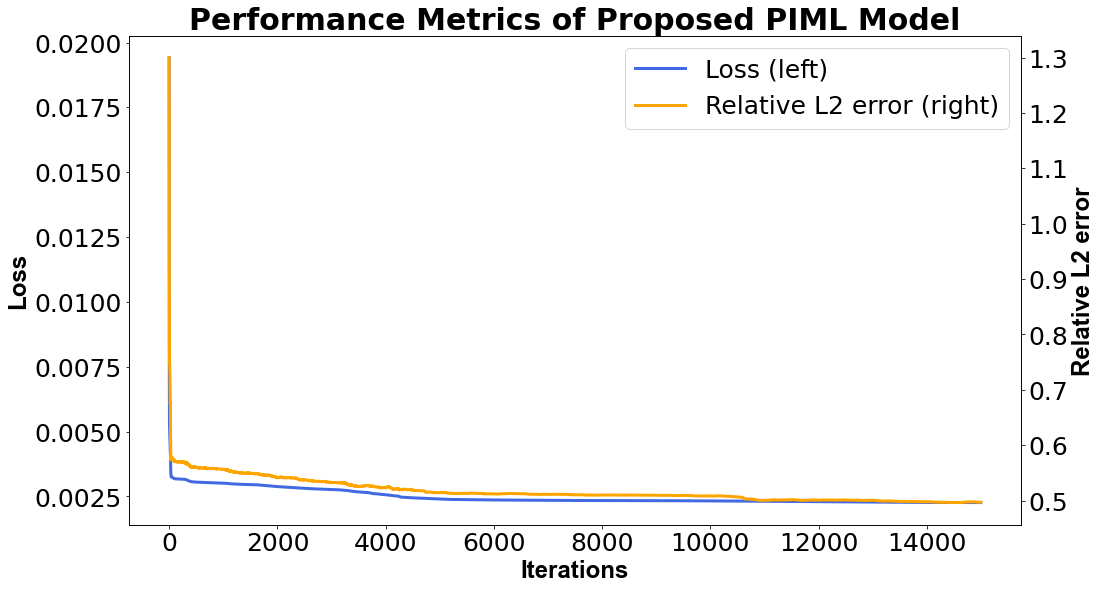

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.02118573837034871
MSE =  0.003144054525916585
RMSE =  0.05607186929215562
L2 relative error = 0.5101210761836025
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

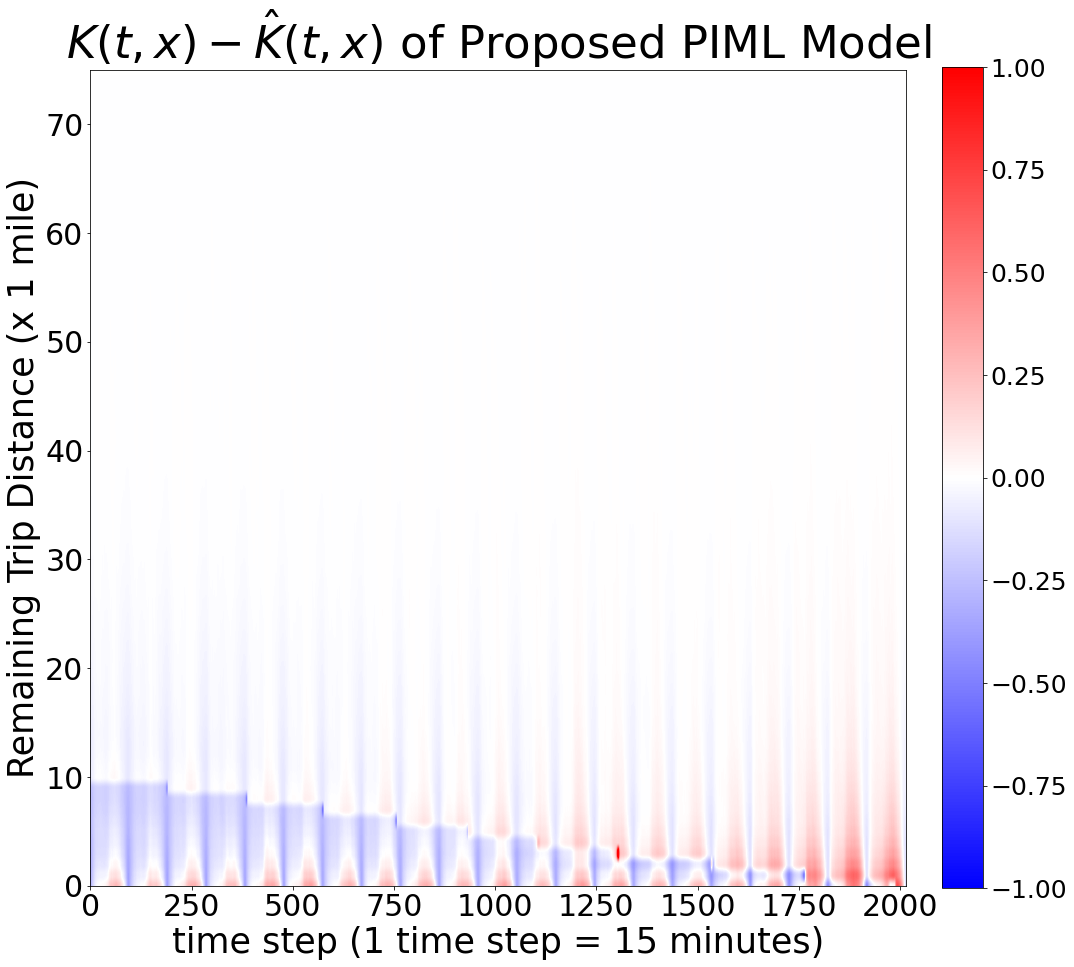

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

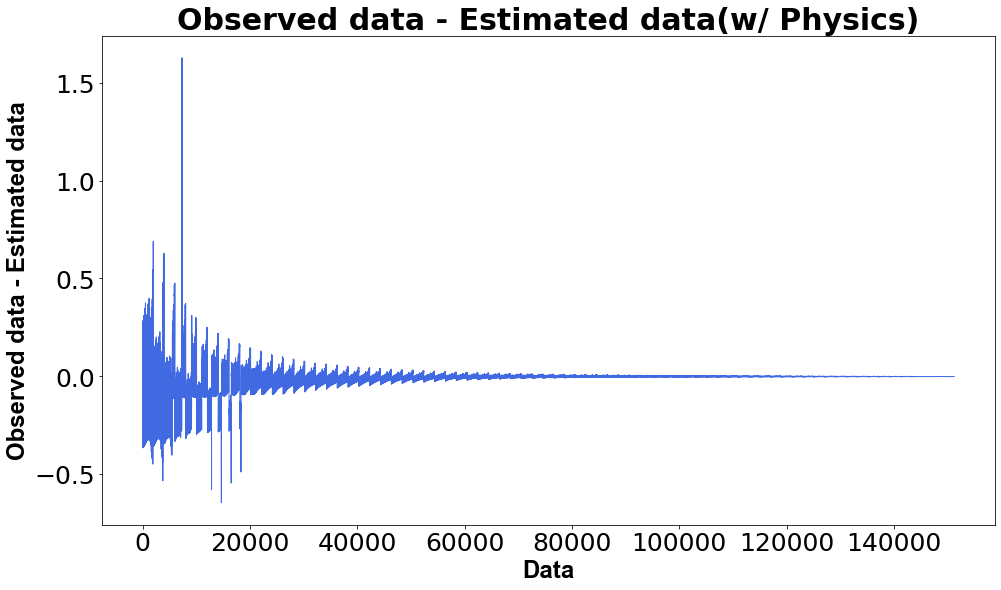

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

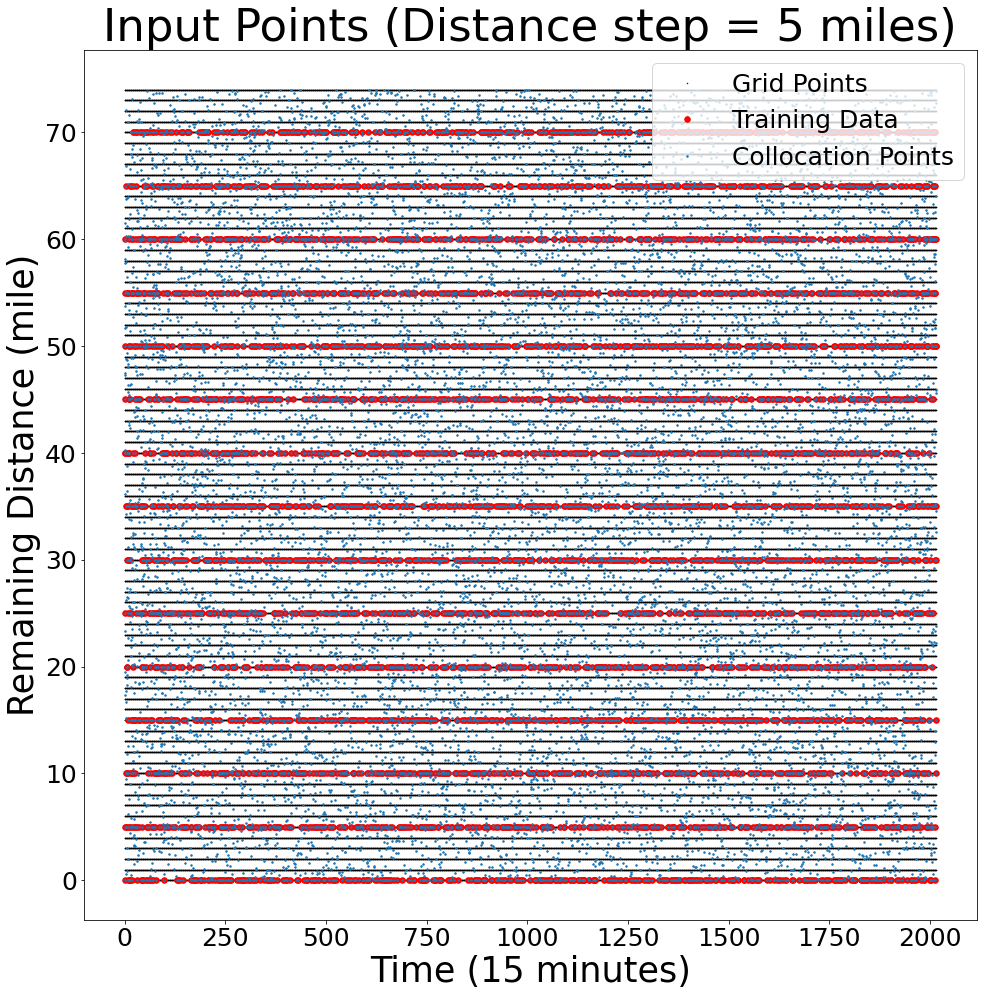

In [21]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 5 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

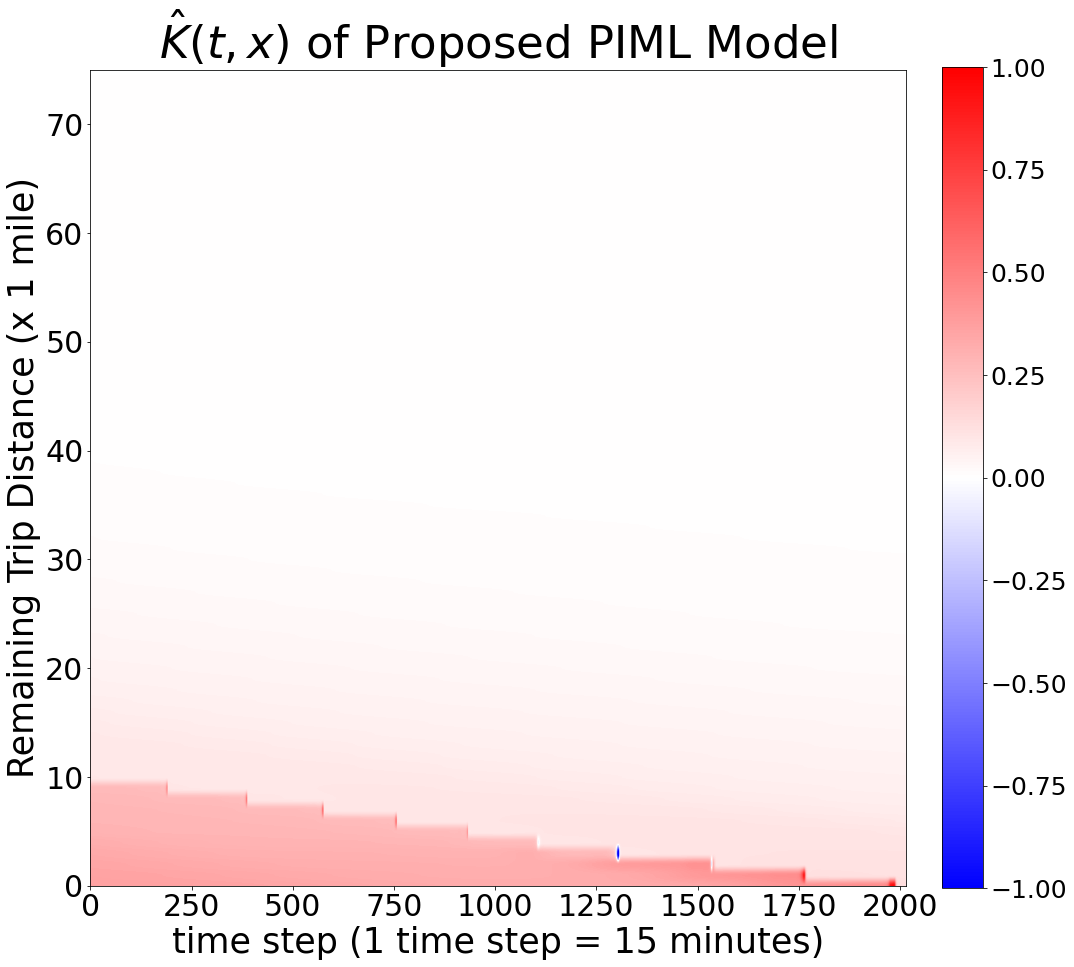

In [22]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)